In [30]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Conv2DTranspose, Flatten, Reshape, LeakyReLU, Dropout
from keras.models import Model, Sequential
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import cv2 as cv
from tqdm import tqdm, trange
from matplotlib import image as mpimg

# Jamming anomaly detection
This python code aims to detect white noise jamming throught the use of machine learning to perform anomaly detection.
\
Constellation diagrams from a cellular wireless channel were taken, and then a ML tool was trained in order to make it learn only what is a "trusted" transmission.
\
By training using only the one class, the detector should recognise only what we consider in prior "trusted", and classify anything else as an anomaly.
\
\
The tool used to perform this operation is a Convolutional Neural Network with a specific structure called *autoencoder*.
\
An autoencoder is a neural network that is composed of two parts: the encoder and the decoder.
<ul>

 <li>the encoder takes the input and performs some operations (such as filtering, pooling etc..) in order to convert it to a lower dimensional space.</li>
 <li>the decoder takes the output of the endcoder and tries to reconstruct the original input.</li>
</ul>
This implies that if the autoencoder is trained only with a dataset composed by only one class, it will learn to reconstruct well only that class.
<br>
In this case, the autoencoder will be fed with i/q diagrams of the cellular wireless channel in the two trusted situations: "Transmitting" in which the cellular device is trasmitting data to the base station and "Empty" in which the cellular device is not transmitting any data to the base station.
<br>
<br>
After that, the mean and the standard deviation of the reconstruction error from the validation set will be computed in order to decide a threshold above that an image is considered an anomaly; in this case the threshold will be set set to mean + stdv.
<br>
At the end, evalutation of the neural network will be performed on a test set composed of 800 images: 400 images are taken from the "trusted" case and 400 are taken from the "jammed case".
<br>
Accuracy of the neural network will be computed by first computing its accuracy(the sum of True positive and true negative samples divided by the length of the test set), then by plotting the confusion matrix in order to show the distribution of the four main KPIs (true positive, true negative, false positive and false negative) in order to have a better overview of the performance of the classifier. 

In [31]:
#name mapping
classes = {0:"clean",1:"jammed"}
mapping={0:0, 1:0, 2:1} ## dictionaries to label the dataset

In [32]:
#downloading the datasets
!pip install -U --no-cache-dir gdown --pre
!pip install --upgrade gdown
import gdown
url = "https://drive.google.com/u/0/uc?id=14bwBwFHrwv3GUyPbp_jbRPxZB3p2QTRB&export=download"
output = "data_gaussian_256.zip"
gdown.download(url, output)
!unzip data_gaussian_256.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=14bwBwFHrwv3GUyPbp_jbRPxZB3p2QTRB&export=download
From (redirected): https://drive.google.com/uc?id=14bwBwFHrwv3GUyPbp_jbRPxZB3p2QTRB&export=download&confirm=t&uuid=6b598652-41a9-4a7f-a5c6-d1dff8cc0f73
To: /content/data_gaussian_256.zip
100%|██████████| 44.9M/44.9M [00:01<00:00, 30.0MB/s]


Output streaming troncato alle ultime 5000 righe.
  inflating: data_gaussian_256/clean/images/1_1695.png  
  inflating: data_gaussian_256/clean/images/1_1696.png  
  inflating: data_gaussian_256/clean/images/1_1697.png  
  inflating: data_gaussian_256/clean/images/1_1710.png  
  inflating: data_gaussian_256/clean/images/1_1711.png  
  inflating: data_gaussian_256/clean/images/1_1712.png  
  inflating: data_gaussian_256/clean/images/1_1714.png  
  inflating: data_gaussian_256/clean/images/1_1715.png  
  inflating: data_gaussian_256/clean/images/1_1716.png  
  inflating: data_gaussian_256/clean/images/1_1719.png  
  inflating: data_gaussian_256/clean/images/1_1723.png  
  inflating: data_gaussian_256/clean/images/1_1724.png  
  inflating: data_gaussian_256/clean/images/1_1726.png  
  inflating: data_gaussian_256/clean/images/1_1727.png  
  inflating: data_gaussian_256/clean/images/1_1728.png  
  inflating: data_gaussian_256/clean/images/1_1737.png  
  inflating: data_gaussian_256/clean/i

In [33]:
clean = []
labels_clean =[]
val = []
labels_val =[]
anomalies = []
labels_anomalies =[]
test=[]
labels_test=[]
## empty arrays that will contain the images of the four datasets and the labels of the corresponding images; in this case 0 is a clean channel and 1 is a jammed channel
for folder in tqdm(os.listdir("data_gaussian_256")):
  print(folder)
  for im in tqdm(os.listdir("data_gaussian_256/"+folder+"/images/")):
      if folder == "clean":
          clean.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_256/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_clean.append(0)
      elif folder == "clean_validation":
          val.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_256/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_val.append(0)
      elif folder== "jammed_channel":
          anomalies.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_256/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_anomalies.append(1)
      else:
        test.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_256/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
        labels_test.append(mapping[int(im[0])])
  ## the images were loaded and put in the lists, but was performed also the resize of the image to 128x128 and conversion of the colorspace from rgb to grayscale
                    

  0%|          | 0/4 [00:00<?, ?it/s]

clean



 25%|██▌       | 1/4 [00:25<01:16, 25.34s/it]

jammed_channel



 50%|█████     | 2/4 [00:31<00:28, 14.29s/it]

test



 75%|███████▌  | 3/4 [00:37<00:10, 10.10s/it]

clean_validation



100%|██████████| 4/4 [00:40<00:00, 10.01s/it]


In [34]:
clean[60].shape ## test only to see if i have an image with the correct size

(128, 128, 1)

In [35]:
## define our neural network
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Sequential([
            Conv2D(64, 3, strides=2, padding="same", activation="sigmoid", input_shape=(128,128,1)),
            Conv2D(32, 3, strides=2, padding="same", activation="sigmoid"),
            Flatten(),
            Dense(32, activation = "sigmoid")
        ])
        self.decoder = Sequential([                            
            Dense(32*32*32, activation="sigmoid",input_shape=self.encoder.output.shape[1:]),
            Reshape((32,32,32)),
            Conv2DTranspose(32, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2DTranspose(64, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2D(1, 3, strides=1, padding="same", activation="sigmoid")
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [36]:
model = AutoEncoder()

model.compile(optimizer='adam', loss="mse")
print(model.encoder.summary())
print(model.decoder.summary())
## print the summary of the autoencoder 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        640       
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                1048608   
                                                                 
Total params: 1,067,712
Trainable params: 1,067,712
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense) 

Summary of the encoder:



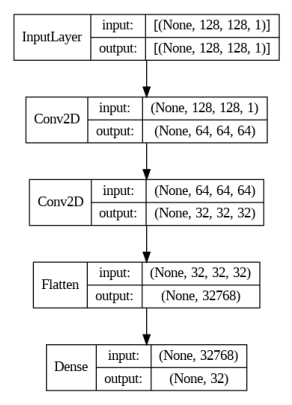

Summary of the decoder:



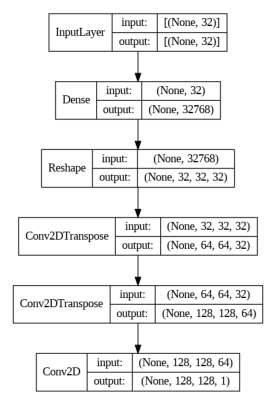

In [ ]:
##plot a scheme of the neural network
print("Summary of the encoder:\n")
image = mpimg.imread("model_encoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()
print("Summary of the decoder:\n")
image = mpimg.imread("model_decoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()

In [37]:
history=model.fit(
        x=np.array(clean)/255.,
        y=np.array(clean)/255.,
        batch_size=32,
        epochs=20,
        verbose=True,
        validation_data=(np.array(val)/255.,np.array(val)/255.), 
        shuffle=True,
    )
## the input of the NN is normalized

## training the NN and computing the error also in the validation set

Epoch 1/20
125/125 [==============================] - 9s 54ms/step - loss: 0.0070 - val_loss: 0.0060
Epoch 2/20
125/125 [==============================] - 6s 51ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 3/20
125/125 [==============================] - 7s 55ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 4/20
125/125 [==============================] - 7s 54ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 5/20
125/125 [==============================] - 6s 50ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 6/20
125/125 [==============================] - 6s 45ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 7/20
125/125 [==============================] - 6s 47ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 8/20
125/125 [==============================] - 6s 46ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 9/20
125/125 [==============================] - 6s 44ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 10/20
125/125 [==============================] - 6s 44ms/step - loss: 0.0061 - val_lo

In [ ]:
model.save("AUTOENCODER_model")
np.save("AUTOENCODER_history.npy", history.history)
print(output.OKGREEN+"Autoencoder saved"+output.END)

else:



  !unzip AUTOENCODER_model.zip

  model = keras.models.load_model("content/AUTOENCODER_model")

  history = np.load("AUTOENCODER_history.npy", allow_pickle = "TRUE").item()

  print(output.OKGREEN+"Autoencoder loaded"+output.END)
## for saving purposes: DONT EXECUTE!! 

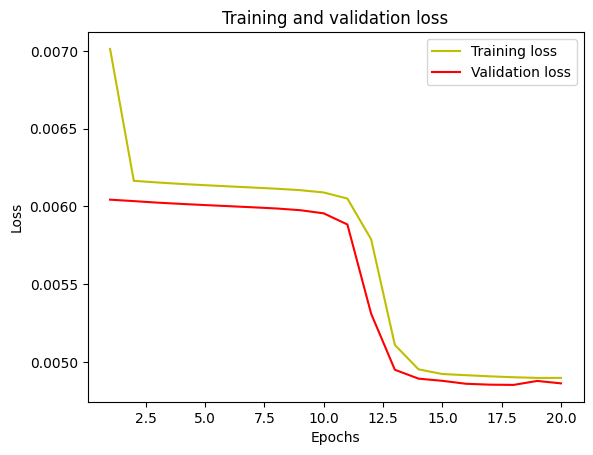

In [38]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
predicted = model.predict((np.array(val))/255.) ## reconstruct some images

19/19 [==============================] - 1s 20ms/step


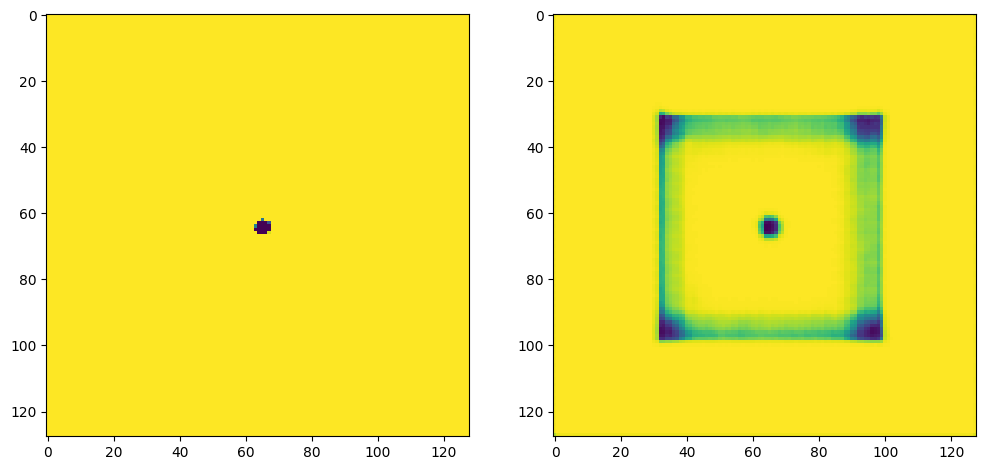

In [40]:
##view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(val[image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()
## examples of the reconstruction of the images, as we can see, the NN has learnt what are the two cases of the channel: "transmitting", in which we can see dots
## that form a square, and "empty", in which we see all the dots concentrated around the origin of the axis

In [41]:
validation_error = model.evaluate((np.array(val)/255.),(np.array(val)/255.))
anomaly_error = model.evaluate((np.array(anomalies)/255.),(np.array(anomalies)/255.))
print("Validation error", validation_error)
print("Anomaly error", anomaly_error)
print("The reconstruction error of the jammed channel is ",anomaly_error/validation_error," more than the clean channel" )
## check if the reconstruction error is higher on some anomaly images

16/16 [==============================] - 0s 20ms/step - loss: 0.0183
Validation error 0.004863230977207422
Anomaly error 0.01828751713037491
The reconstruction error of the jammed channel is  3.7603636792254553  more than the clean channel


In [42]:
## functions that computes the mean and the stdv of the reconstruction error
def calc_recon_error(batch_images):

    recon_error_list=[]
    for im in trange(0, batch_images.shape[0]):
        
        img  = batch_images[im]
        img= img.reshape(1,128,128,1)
        recon_error_list.append(model.evaluate(img,img))
         
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list))
    maximum= max(recon_error_list) 
    minimum= min(recon_error_list)
    
    return average_recon_error, stdev_recon_error, maximum, minimum

In [43]:
normal_values = calc_recon_error(np.array(val)/255.)
jammed_values = calc_recon_error(np.array(anomalies)/255.)
## compute the statistics on the reconstruction error of both cases

  0%|          | 0/600 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0091


  0%|          | 2/600 [00:00<00:42, 13.93it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0070


  1%|          | 4/600 [00:00<00:42, 13.96it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0015


  1%|          | 6/600 [00:00<00:41, 14.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0064


  1%|▏         | 8/600 [00:00<00:41, 14.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


  2%|▏         | 10/600 [00:00<00:41, 14.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0070


  2%|▏         | 12/600 [00:00<00:40, 14.62it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0093


  2%|▏         | 14/600 [00:00<00:40, 14.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0015


  3%|▎         | 16/600 [00:01<00:41, 14.12it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0103


  3%|▎         | 18/600 [00:01<00:43, 13.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0062


  3%|▎         | 20/600 [00:01<00:41, 14.12it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0092


  4%|▎         | 22/600 [00:01<00:43, 13.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0015


  4%|▍         | 24/600 [00:01<00:41, 13.93it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0015


  4%|▍         | 26/600 [00:01<00:40, 14.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


  5%|▍         | 28/600 [00:01<00:39, 14.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0094


  5%|▌         | 30/600 [00:02<00:39, 14.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0071


  5%|▌         | 32/600 [00:02<00:38, 14.57it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0068


  6%|▌         | 34/600 [00:02<00:39, 14.44it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0068


  6%|▌         | 36/600 [00:02<00:39, 14.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0021


  6%|▋         | 38/600 [00:02<00:40, 13.82it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0016


  7%|▋         | 40/600 [00:02<00:41, 13.36it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0021


  7%|▋         | 42/600 [00:02<00:41, 13.56it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0091


  7%|▋         | 44/600 [00:03<00:46, 12.00it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0064


  8%|▊         | 46/600 [00:03<00:56,  9.76it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0098


  8%|▊         | 48/600 [00:03<00:57,  9.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0070


  8%|▊         | 50/600 [00:03<00:52, 10.48it/s]

1/1 [==============================] - 0s 56ms/step - loss: 0.0089


  9%|▊         | 52/600 [00:04<01:02,  8.77it/s]

1/1 [==============================] - 0s 56ms/step - loss: 0.0015


  9%|▉         | 53/600 [00:04<01:08,  7.94it/s]

1/1 [==============================] - 0s 69ms/step - loss: 0.0015


  9%|▉         | 54/600 [00:04<01:11,  7.66it/s]

1/1 [==============================] - 0s 55ms/step - loss: 0.0015


  9%|▉         | 55/600 [00:04<01:11,  7.59it/s]

1/1 [==============================] - 0s 94ms/step - loss: 0.0075


  9%|▉         | 56/600 [00:04<01:21,  6.67it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0016


 10%|▉         | 57/600 [00:05<01:27,  6.21it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0019


 10%|▉         | 58/600 [00:05<01:27,  6.19it/s]

1/1 [==============================] - 0s 85ms/step - loss: 0.0015


 10%|▉         | 59/600 [00:05<01:36,  5.59it/s]

1/1 [==============================] - 0s 110ms/step - loss: 0.0015


 10%|█         | 60/600 [00:05<01:38,  5.48it/s]

1/1 [==============================] - 0s 62ms/step - loss: 0.0108


 10%|█         | 61/600 [00:05<01:33,  5.78it/s]

1/1 [==============================] - 0s 80ms/step - loss: 0.0070


 10%|█         | 62/600 [00:05<01:32,  5.83it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0077


 10%|█         | 63/600 [00:06<01:24,  6.36it/s]

1/1 [==============================] - 0s 99ms/step - loss: 0.0015


 11%|█         | 64/600 [00:06<01:40,  5.32it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0062


 11%|█         | 65/600 [00:06<01:32,  5.75it/s]

1/1 [==============================] - 0s 102ms/step - loss: 0.0094


 11%|█         | 66/600 [00:06<01:41,  5.26it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0015


 11%|█         | 67/600 [00:06<01:40,  5.28it/s]

1/1 [==============================] - 0s 82ms/step - loss: 0.0069


 11%|█▏        | 68/600 [00:07<01:42,  5.17it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0020


 12%|█▏        | 69/600 [00:07<01:29,  5.91it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0066


 12%|█▏        | 70/600 [00:07<01:23,  6.35it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0067


 12%|█▏        | 71/600 [00:07<01:22,  6.39it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0096


 12%|█▏        | 72/600 [00:07<01:17,  6.86it/s]

1/1 [==============================] - 0s 106ms/step - loss: 0.0016


 12%|█▏        | 73/600 [00:07<01:26,  6.11it/s]

1/1 [==============================] - 0s 61ms/step - loss: 0.0102


 12%|█▏        | 74/600 [00:08<01:30,  5.84it/s]

1/1 [==============================] - 0s 125ms/step - loss: 0.0069


 12%|█▎        | 75/600 [00:08<01:39,  5.25it/s]

1/1 [==============================] - 0s 56ms/step - loss: 0.0019


 13%|█▎        | 76/600 [00:08<01:36,  5.45it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0015


 13%|█▎        | 77/600 [00:08<01:35,  5.50it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0015


 13%|█▎        | 78/600 [00:08<01:36,  5.39it/s]

1/1 [==============================] - 0s 113ms/step - loss: 0.0090


 13%|█▎        | 79/600 [00:09<01:44,  5.00it/s]

1/1 [==============================] - 0s 178ms/step - loss: 0.0068


 13%|█▎        | 80/600 [00:09<02:23,  3.63it/s]

1/1 [==============================] - 0s 202ms/step - loss: 0.0071


 14%|█▎        | 81/600 [00:09<03:01,  2.86it/s]

1/1 [==============================] - 0s 116ms/step - loss: 0.0072


 14%|█▎        | 82/600 [00:10<02:57,  2.91it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0015


 14%|█▍        | 83/600 [00:10<02:28,  3.49it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0019


 14%|█▍        | 84/600 [00:10<02:00,  4.29it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0072


 14%|█▍        | 86/600 [00:10<01:26,  5.96it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0015


 15%|█▍        | 88/600 [00:10<01:09,  7.36it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0019


 15%|█▌        | 90/600 [00:11<01:00,  8.40it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0072


 15%|█▌        | 91/600 [00:11<00:59,  8.56it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0099


 15%|█▌        | 92/600 [00:11<00:58,  8.70it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0084


 16%|█▌        | 94/600 [00:11<00:53,  9.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 16%|█▌        | 96/600 [00:11<00:48, 10.37it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0072


 16%|█▋        | 98/600 [00:11<00:43, 11.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0022


 17%|█▋        | 100/600 [00:11<00:41, 11.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


 17%|█▋        | 102/600 [00:12<00:39, 12.67it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0070


 17%|█▋        | 104/600 [00:12<00:37, 13.22it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0066


 18%|█▊        | 106/600 [00:12<00:36, 13.67it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0020


 18%|█▊        | 108/600 [00:12<00:35, 13.74it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0067


 18%|█▊        | 110/600 [00:12<00:35, 13.98it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0096


 19%|█▊        | 112/600 [00:12<00:34, 14.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0021


 19%|█▉        | 114/600 [00:12<00:33, 14.50it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


 19%|█▉        | 116/600 [00:13<00:34, 14.09it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0019


 20%|█▉        | 118/600 [00:13<00:34, 14.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0084


 20%|██        | 120/600 [00:13<00:32, 14.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


 20%|██        | 122/600 [00:13<00:32, 14.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0070


 21%|██        | 124/600 [00:13<00:32, 14.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0087


 21%|██        | 126/600 [00:13<00:32, 14.63it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0073


 21%|██▏       | 128/600 [00:13<00:33, 14.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0100


 22%|██▏       | 130/600 [00:14<00:32, 14.32it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0074


 22%|██▏       | 132/600 [00:14<00:32, 14.44it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 22%|██▏       | 134/600 [00:14<00:32, 14.20it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0015


 23%|██▎       | 136/600 [00:14<00:32, 14.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0016


 23%|██▎       | 138/600 [00:14<00:31, 14.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0020


 23%|██▎       | 140/600 [00:14<00:32, 14.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0015


 24%|██▎       | 142/600 [00:14<00:32, 14.25it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0096


 24%|██▍       | 144/600 [00:15<00:31, 14.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0073


 24%|██▍       | 146/600 [00:15<00:31, 14.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


 25%|██▍       | 148/600 [00:15<00:31, 14.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0021


 25%|██▌       | 150/600 [00:15<00:31, 14.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0073


 25%|██▌       | 152/600 [00:15<00:30, 14.70it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0015


 26%|██▌       | 154/600 [00:15<00:30, 14.71it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0096


 26%|██▌       | 156/600 [00:15<00:30, 14.76it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0019


 26%|██▋       | 158/600 [00:15<00:30, 14.28it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


 27%|██▋       | 160/600 [00:16<00:30, 14.20it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0070


 27%|██▋       | 162/600 [00:16<00:30, 14.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 27%|██▋       | 164/600 [00:16<00:30, 14.35it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0015


 28%|██▊       | 166/600 [00:16<00:30, 14.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0071


 28%|██▊       | 168/600 [00:16<00:29, 14.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 28%|██▊       | 170/600 [00:16<00:29, 14.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 29%|██▊       | 172/600 [00:16<00:30, 14.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0075


 29%|██▉       | 174/600 [00:17<00:29, 14.68it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0098


 29%|██▉       | 176/600 [00:17<00:28, 14.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


 30%|██▉       | 178/600 [00:17<00:29, 14.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0077


 30%|███       | 180/600 [00:17<00:29, 14.31it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0096


 30%|███       | 182/600 [00:17<00:28, 14.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0067


 31%|███       | 184/600 [00:17<00:28, 14.55it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0020


 31%|███       | 186/600 [00:17<00:28, 14.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0067


 31%|███▏      | 188/600 [00:18<00:28, 14.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0092


 32%|███▏      | 190/600 [00:18<00:28, 14.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0096


 32%|███▏      | 192/600 [00:18<00:28, 14.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0020


 32%|███▏      | 194/600 [00:18<00:28, 14.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 33%|███▎      | 196/600 [00:18<00:28, 14.26it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0018


 33%|███▎      | 198/600 [00:18<00:28, 13.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


 33%|███▎      | 200/600 [00:18<00:27, 14.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 34%|███▎      | 202/600 [00:19<00:27, 14.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0015


 34%|███▍      | 204/600 [00:19<00:27, 14.61it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0021


 34%|███▍      | 206/600 [00:19<00:27, 14.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0073


 35%|███▍      | 208/600 [00:19<00:26, 14.64it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0015


 35%|███▌      | 210/600 [00:19<00:26, 14.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0021


 35%|███▌      | 212/600 [00:19<00:26, 14.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0095


 36%|███▌      | 214/600 [00:19<00:26, 14.81it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0082


 36%|███▌      | 216/600 [00:19<00:26, 14.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0099


 36%|███▋      | 218/600 [00:20<00:26, 14.48it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0094


 37%|███▋      | 220/600 [00:20<00:26, 14.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0069


 37%|███▋      | 222/600 [00:20<00:27, 14.00it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0020


 37%|███▋      | 224/600 [00:20<00:26, 14.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


 38%|███▊      | 226/600 [00:20<00:25, 14.55it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0067


 38%|███▊      | 228/600 [00:20<00:25, 14.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0019


 38%|███▊      | 230/600 [00:20<00:26, 13.83it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


 39%|███▊      | 232/600 [00:21<00:26, 13.98it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0102


 39%|███▉      | 234/600 [00:21<00:25, 14.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


 39%|███▉      | 236/600 [00:21<00:26, 13.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 40%|███▉      | 238/600 [00:21<00:25, 14.20it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0020


 40%|████      | 240/600 [00:21<00:27, 12.99it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0085


 40%|████      | 242/600 [00:21<00:29, 12.27it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0015


 41%|████      | 244/600 [00:22<00:30, 11.61it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0021


 41%|████      | 246/600 [00:22<00:32, 11.05it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0016


 41%|████▏     | 248/600 [00:22<00:32, 10.86it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0019


 42%|████▏     | 250/600 [00:22<00:31, 11.03it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0015


 42%|████▏     | 252/600 [00:22<00:31, 11.11it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0101


 42%|████▏     | 254/600 [00:23<00:32, 10.53it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0070


 43%|████▎     | 256/600 [00:23<00:34,  9.96it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0020


 43%|████▎     | 258/600 [00:23<00:34, 10.03it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0016


 43%|████▎     | 260/600 [00:23<00:33, 10.04it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0020


 44%|████▎     | 262/600 [00:23<00:33, 10.12it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0020


 44%|████▍     | 264/600 [00:24<00:33,  9.94it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0069


 44%|████▍     | 265/600 [00:24<00:33,  9.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0015


 44%|████▍     | 267/600 [00:24<00:30, 10.96it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0095


 45%|████▍     | 269/600 [00:24<00:28, 11.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0019


 45%|████▌     | 271/600 [00:24<00:26, 12.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0085


 46%|████▌     | 273/600 [00:24<00:25, 12.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0016


 46%|████▌     | 275/600 [00:24<00:24, 13.34it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0016


 46%|████▌     | 277/600 [00:25<00:23, 13.63it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0065


 46%|████▋     | 279/600 [00:25<00:23, 13.60it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0072


 47%|████▋     | 281/600 [00:25<00:22, 13.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0059


 47%|████▋     | 283/600 [00:25<00:22, 14.21it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0072


 48%|████▊     | 285/600 [00:25<00:21, 14.40it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0090


 48%|████▊     | 287/600 [00:25<00:22, 14.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0071


 48%|████▊     | 289/600 [00:25<00:21, 14.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0067


 48%|████▊     | 291/600 [00:26<00:21, 14.19it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0019


 49%|████▉     | 293/600 [00:26<00:22, 13.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0088


 49%|████▉     | 295/600 [00:26<00:22, 13.44it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 50%|████▉     | 297/600 [00:26<00:21, 13.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0068


 50%|████▉     | 299/600 [00:26<00:21, 14.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0085


 50%|█████     | 301/600 [00:26<00:21, 13.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0020


 50%|█████     | 303/600 [00:26<00:21, 13.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0065


 51%|█████     | 305/600 [00:27<00:20, 14.12it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 51%|█████     | 307/600 [00:27<00:21, 13.90it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0092


 52%|█████▏    | 309/600 [00:27<00:21, 13.67it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0101


 52%|█████▏    | 311/600 [00:27<00:21, 13.61it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 52%|█████▏    | 313/600 [00:27<00:21, 13.63it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0072


 52%|█████▎    | 315/600 [00:27<00:21, 13.54it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0071


 53%|█████▎    | 317/600 [00:27<00:20, 14.10it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0066


 53%|█████▎    | 319/600 [00:28<00:20, 13.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0075


 54%|█████▎    | 321/600 [00:28<00:19, 13.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0097


 54%|█████▍    | 323/600 [00:28<00:19, 13.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0019


 54%|█████▍    | 325/600 [00:28<00:19, 13.80it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0089


 55%|█████▍    | 327/600 [00:28<00:19, 13.70it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0019


 55%|█████▍    | 329/600 [00:28<00:19, 13.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0073


 55%|█████▌    | 331/600 [00:28<00:19, 14.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


 56%|█████▌    | 333/600 [00:29<00:18, 14.29it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0015


 56%|█████▌    | 335/600 [00:29<00:18, 14.19it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


 56%|█████▌    | 337/600 [00:29<00:18, 14.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0016


 56%|█████▋    | 339/600 [00:29<00:18, 14.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


 57%|█████▋    | 341/600 [00:29<00:17, 14.55it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0069


 57%|█████▋    | 343/600 [00:29<00:18, 14.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 57%|█████▊    | 345/600 [00:29<00:17, 14.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0090


 58%|█████▊    | 347/600 [00:30<00:17, 14.36it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0073


 58%|█████▊    | 349/600 [00:30<00:17, 13.99it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0098


 58%|█████▊    | 351/600 [00:30<00:18, 13.58it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0078


 59%|█████▉    | 353/600 [00:30<00:17, 13.79it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0020


 59%|█████▉    | 355/600 [00:30<00:17, 13.91it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0019


 60%|█████▉    | 357/600 [00:30<00:17, 14.19it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0016


 60%|█████▉    | 359/600 [00:30<00:17, 13.69it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0015


 60%|██████    | 361/600 [00:31<00:17, 13.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0020


 60%|██████    | 363/600 [00:31<00:16, 13.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


 61%|██████    | 365/600 [00:31<00:16, 13.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0086


 61%|██████    | 367/600 [00:31<00:17, 13.36it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0015


 62%|██████▏   | 369/600 [00:31<00:17, 13.53it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


 62%|██████▏   | 371/600 [00:31<00:16, 13.99it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0019


 62%|██████▏   | 373/600 [00:31<00:16, 13.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0016


 62%|██████▎   | 375/600 [00:32<00:16, 14.03it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0020


 63%|██████▎   | 377/600 [00:32<00:16, 13.87it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0019


 63%|██████▎   | 379/600 [00:32<00:15, 13.91it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0071


 64%|██████▎   | 381/600 [00:32<00:15, 14.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 64%|██████▍   | 383/600 [00:32<00:15, 13.87it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


 64%|██████▍   | 385/600 [00:32<00:15, 14.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


 64%|██████▍   | 387/600 [00:32<00:15, 13.67it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 65%|██████▍   | 389/600 [00:33<00:15, 13.84it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


 65%|██████▌   | 391/600 [00:33<00:15, 13.74it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0089


 66%|██████▌   | 393/600 [00:33<00:14, 13.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0085


 66%|██████▌   | 395/600 [00:33<00:15, 13.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0068


 66%|██████▌   | 397/600 [00:33<00:14, 13.70it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0020


 66%|██████▋   | 399/600 [00:33<00:14, 13.44it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0015


 67%|██████▋   | 401/600 [00:34<00:28,  6.87it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0016


 67%|██████▋   | 403/600 [00:34<00:26,  7.47it/s]

1/1 [==============================] - 0s 57ms/step - loss: 0.0016


 68%|██████▊   | 405/600 [00:34<00:24,  7.84it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0091


 68%|██████▊   | 407/600 [00:35<00:22,  8.50it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0015


 68%|██████▊   | 408/600 [00:35<00:22,  8.50it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0015


 68%|██████▊   | 409/600 [00:35<00:22,  8.66it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0015


 68%|██████▊   | 410/600 [00:35<00:21,  8.73it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0015


 68%|██████▊   | 411/600 [00:35<00:21,  8.97it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0015


 69%|██████▊   | 412/600 [00:35<00:21,  8.93it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0016


 69%|██████▉   | 413/600 [00:35<00:20,  9.03it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0015


 69%|██████▉   | 414/600 [00:35<00:20,  9.13it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0015


 69%|██████▉   | 415/600 [00:35<00:19,  9.27it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0015


 69%|██████▉   | 416/600 [00:36<00:20,  8.97it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0073


 70%|██████▉   | 417/600 [00:36<00:20,  8.85it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0015


 70%|██████▉   | 418/600 [00:36<00:20,  9.05it/s]

1/1 [==============================] - 0s 55ms/step - loss: 0.0087


 70%|██████▉   | 419/600 [00:36<00:20,  8.90it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0069


 70%|███████   | 420/600 [00:36<00:19,  9.01it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0015


 70%|███████   | 421/600 [00:36<00:19,  9.15it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0020


 70%|███████   | 422/600 [00:36<00:19,  9.17it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0019


 70%|███████   | 423/600 [00:36<00:19,  9.16it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0071


 71%|███████   | 425/600 [00:37<00:17, 10.11it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0015


 71%|███████   | 427/600 [00:37<00:15, 11.10it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0065


 72%|███████▏  | 429/600 [00:37<00:14, 11.44it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0096


 72%|███████▏  | 431/600 [00:37<00:14, 12.00it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0022


 72%|███████▏  | 433/600 [00:37<00:13, 12.25it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0020


 72%|███████▎  | 435/600 [00:37<00:13, 12.17it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0015


 73%|███████▎  | 437/600 [00:37<00:13, 11.81it/s]

1/1 [==============================] - 0s 83ms/step - loss: 0.0084


 73%|███████▎  | 439/600 [00:38<00:20,  8.05it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0015


 73%|███████▎  | 440/600 [00:38<00:20,  7.96it/s]

1/1 [==============================] - 0s 56ms/step - loss: 0.0019


 74%|███████▎  | 441/600 [00:38<00:21,  7.49it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0070


 74%|███████▎  | 442/600 [00:38<00:20,  7.74it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0015


 74%|███████▍  | 443/600 [00:38<00:21,  7.33it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0089


 74%|███████▍  | 444/600 [00:39<00:20,  7.46it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0020


 74%|███████▍  | 445/600 [00:39<00:20,  7.47it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0015


 74%|███████▍  | 446/600 [00:39<00:20,  7.62it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0094


 74%|███████▍  | 447/600 [00:39<00:21,  7.21it/s]

1/1 [==============================] - 0s 59ms/step - loss: 0.0063


 75%|███████▍  | 448/600 [00:39<00:20,  7.25it/s]

1/1 [==============================] - 0s 71ms/step - loss: 0.0098


 75%|███████▍  | 449/600 [00:39<00:22,  6.85it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0064


 75%|███████▌  | 450/600 [00:39<00:21,  7.00it/s]

1/1 [==============================] - 0s 120ms/step - loss: 0.0064


 75%|███████▌  | 451/600 [00:40<00:24,  6.06it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0015


 75%|███████▌  | 452/600 [00:40<00:22,  6.48it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0015


 76%|███████▌  | 453/600 [00:40<00:21,  6.98it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0089


 76%|███████▌  | 454/600 [00:40<00:21,  6.64it/s]

1/1 [==============================] - 0s 54ms/step - loss: 0.0015


 76%|███████▌  | 455/600 [00:40<00:22,  6.43it/s]

1/1 [==============================] - 0s 54ms/step - loss: 0.0015


 76%|███████▌  | 456/600 [00:40<00:23,  6.23it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0068


 76%|███████▌  | 457/600 [00:41<00:21,  6.62it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0092


 76%|███████▋  | 458/600 [00:41<00:23,  6.03it/s]

1/1 [==============================] - 0s 91ms/step - loss: 0.0016


 76%|███████▋  | 459/600 [00:41<00:23,  6.12it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0071


 77%|███████▋  | 460/600 [00:41<00:23,  5.97it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0015


 77%|███████▋  | 461/600 [00:41<00:21,  6.51it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0095


 77%|███████▋  | 462/600 [00:41<00:19,  7.16it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0096


 77%|███████▋  | 463/600 [00:41<00:18,  7.50it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0090


 77%|███████▋  | 464/600 [00:42<00:17,  7.72it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0068


 78%|███████▊  | 465/600 [00:42<00:17,  7.64it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0084


 78%|███████▊  | 466/600 [00:42<00:21,  6.34it/s]

1/1 [==============================] - 0s 54ms/step - loss: 0.0020


 78%|███████▊  | 467/600 [00:42<00:21,  6.32it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0072


 78%|███████▊  | 468/600 [00:42<00:19,  6.73it/s]

1/1 [==============================] - 0s 56ms/step - loss: 0.0070


 78%|███████▊  | 469/600 [00:42<00:20,  6.55it/s]

1/1 [==============================] - 0s 70ms/step - loss: 0.0018


 78%|███████▊  | 470/600 [00:43<00:19,  6.59it/s]

1/1 [==============================] - 0s 78ms/step - loss: 0.0015


 78%|███████▊  | 471/600 [00:43<00:19,  6.46it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0067


 79%|███████▊  | 472/600 [00:43<00:20,  6.22it/s]

1/1 [==============================] - 0s 62ms/step - loss: 0.0093


 79%|███████▉  | 473/600 [00:43<00:18,  6.70it/s]

1/1 [==============================] - 0s 90ms/step - loss: 0.0015


 79%|███████▉  | 474/600 [00:43<00:20,  6.27it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0068


 79%|███████▉  | 475/600 [00:43<00:18,  6.69it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0019


 79%|███████▉  | 476/600 [00:43<00:17,  7.04it/s]

1/1 [==============================] - 0s 67ms/step - loss: 0.0091


 80%|███████▉  | 477/600 [00:44<00:18,  6.50it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0015


 80%|███████▉  | 478/600 [00:44<00:19,  6.23it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0020


 80%|███████▉  | 479/600 [00:44<00:18,  6.65it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0090


 80%|████████  | 480/600 [00:44<00:17,  7.01it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0021


 80%|████████  | 481/600 [00:44<00:16,  7.32it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0089


 80%|████████  | 482/600 [00:44<00:15,  7.62it/s]

1/1 [==============================] - 0s 57ms/step - loss: 0.0085


 80%|████████  | 483/600 [00:44<00:15,  7.60it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0065


 81%|████████  | 484/600 [00:45<00:15,  7.53it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0064


 81%|████████  | 485/600 [00:45<00:14,  7.92it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0076


 81%|████████  | 486/600 [00:45<00:13,  8.16it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0020


 81%|████████  | 487/600 [00:45<00:13,  8.35it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0015


 81%|████████▏ | 488/600 [00:45<00:13,  8.34it/s]

1/1 [==============================] - 0s 94ms/step - loss: 0.0015


 82%|████████▏ | 489/600 [00:45<00:15,  7.03it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0021


 82%|████████▏ | 490/600 [00:45<00:15,  7.20it/s]

1/1 [==============================] - 0s 64ms/step - loss: 0.0069


 82%|████████▏ | 491/600 [00:45<00:16,  6.56it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0015


 82%|████████▏ | 492/600 [00:46<00:16,  6.54it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0075


 82%|████████▏ | 493/600 [00:46<00:16,  6.53it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0021


 82%|████████▏ | 494/600 [00:46<00:15,  6.86it/s]

1/1 [==============================] - 0s 68ms/step - loss: 0.0089


 82%|████████▎ | 495/600 [00:46<00:15,  6.58it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0092


 83%|████████▎ | 496/600 [00:46<00:15,  6.79it/s]

1/1 [==============================] - 0s 108ms/step - loss: 0.0015


 83%|████████▎ | 497/600 [00:46<00:16,  6.08it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0015


 83%|████████▎ | 498/600 [00:47<00:15,  6.61it/s]

1/1 [==============================] - 0s 89ms/step - loss: 0.0015


 83%|████████▎ | 499/600 [00:47<00:17,  5.78it/s]

1/1 [==============================] - 0s 140ms/step - loss: 0.0072


 83%|████████▎ | 500/600 [00:47<00:20,  4.87it/s]

1/1 [==============================] - 0s 72ms/step - loss: 0.0015


 84%|████████▎ | 501/600 [00:47<00:20,  4.78it/s]

1/1 [==============================] - 0s 89ms/step - loss: 0.0093


 84%|████████▎ | 502/600 [00:47<00:20,  4.84it/s]

1/1 [==============================] - 0s 128ms/step - loss: 0.0074


 84%|████████▍ | 503/600 [00:48<00:22,  4.29it/s]

1/1 [==============================] - 0s 138ms/step - loss: 0.0085


 84%|████████▍ | 504/600 [00:48<00:23,  4.00it/s]

1/1 [==============================] - 0s 69ms/step - loss: 0.0100


 84%|████████▍ | 505/600 [00:48<00:22,  4.31it/s]

1/1 [==============================] - 0s 72ms/step - loss: 0.0015


 84%|████████▍ | 506/600 [00:48<00:21,  4.41it/s]

1/1 [==============================] - 0s 89ms/step - loss: 0.0073


 84%|████████▍ | 507/600 [00:49<00:21,  4.29it/s]

1/1 [==============================] - 0s 75ms/step - loss: 0.0019


 85%|████████▍ | 508/600 [00:49<00:21,  4.38it/s]

1/1 [==============================] - 0s 110ms/step - loss: 0.0068


 85%|████████▍ | 509/600 [00:49<00:20,  4.38it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0080


 85%|████████▌ | 510/600 [00:49<00:17,  5.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0015


 85%|████████▌ | 512/600 [00:49<00:12,  7.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


 86%|████████▌ | 514/600 [00:50<00:09,  8.77it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0020


 86%|████████▌ | 516/600 [00:50<00:08,  9.68it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0070


 86%|████████▋ | 518/600 [00:50<00:07, 10.79it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0064


 87%|████████▋ | 520/600 [00:50<00:06, 11.65it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0083


 87%|████████▋ | 522/600 [00:50<00:06, 12.26it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0019


 87%|████████▋ | 524/600 [00:50<00:06, 12.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0016


 88%|████████▊ | 526/600 [00:50<00:05, 12.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


 88%|████████▊ | 528/600 [00:51<00:05, 12.84it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0074


 88%|████████▊ | 530/600 [00:51<00:05, 13.25it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0073


 89%|████████▊ | 532/600 [00:51<00:05, 13.33it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0019


 89%|████████▉ | 534/600 [00:51<00:04, 13.22it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


 89%|████████▉ | 536/600 [00:51<00:04, 13.48it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0019


 90%|████████▉ | 538/600 [00:51<00:04, 13.37it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0078


 90%|█████████ | 540/600 [00:52<00:04, 12.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0091


 90%|█████████ | 542/600 [00:52<00:04, 13.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0019


 91%|█████████ | 544/600 [00:52<00:04, 13.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0019


 91%|█████████ | 546/600 [00:52<00:03, 13.66it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0015


 91%|█████████▏| 548/600 [00:52<00:03, 13.41it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0093


 92%|█████████▏| 550/600 [00:52<00:03, 13.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0016


 92%|█████████▏| 552/600 [00:52<00:03, 13.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 92%|█████████▏| 554/600 [00:53<00:03, 13.97it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0097


 93%|█████████▎| 556/600 [00:53<00:03, 13.45it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0015


 93%|█████████▎| 558/600 [00:53<00:03, 13.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0092


 93%|█████████▎| 560/600 [00:53<00:02, 13.71it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0088


 94%|█████████▎| 562/600 [00:53<00:02, 13.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


 94%|█████████▍| 564/600 [00:53<00:02, 13.62it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0021


 94%|█████████▍| 566/600 [00:53<00:02, 13.45it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0095


 95%|█████████▍| 568/600 [00:54<00:02, 13.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0072


 95%|█████████▌| 570/600 [00:54<00:02, 13.35it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0020


 95%|█████████▌| 572/600 [00:54<00:02, 13.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


 96%|█████████▌| 574/600 [00:54<00:01, 13.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0073


 96%|█████████▌| 576/600 [00:54<00:01, 13.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0096


 96%|█████████▋| 578/600 [00:54<00:01, 13.00it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0019


 97%|█████████▋| 580/600 [00:55<00:01, 13.21it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0078


 97%|█████████▋| 582/600 [00:55<00:01, 13.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0063


 97%|█████████▋| 584/600 [00:55<00:01, 13.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0015


 98%|█████████▊| 586/600 [00:55<00:01, 13.75it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0066


 98%|█████████▊| 588/600 [00:55<00:00, 13.73it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0015


 98%|█████████▊| 590/600 [00:55<00:00, 13.88it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0093


 99%|█████████▊| 592/600 [00:55<00:00, 13.89it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0016


 99%|█████████▉| 594/600 [00:56<00:00, 13.91it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0021


 99%|█████████▉| 596/600 [00:56<00:00, 13.45it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0094


100%|█████████▉| 598/600 [00:56<00:00, 13.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0186


  0%|          | 1/500 [00:00<00:50,  9.85it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0178


  1%|          | 3/500 [00:00<00:40, 12.16it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


  1%|          | 5/500 [00:00<00:39, 12.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


  1%|▏         | 7/500 [00:00<00:37, 13.07it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0185


  2%|▏         | 9/500 [00:00<00:36, 13.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0187


  2%|▏         | 11/500 [00:00<00:36, 13.31it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0179


  3%|▎         | 13/500 [00:01<00:36, 13.22it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0181


  3%|▎         | 15/500 [00:01<00:36, 13.32it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0183


  3%|▎         | 17/500 [00:01<00:37, 12.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0188


  4%|▍         | 19/500 [00:01<00:38, 12.46it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0186


  4%|▍         | 21/500 [00:01<00:37, 12.72it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0187


  5%|▍         | 23/500 [00:01<00:36, 12.94it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0186


  5%|▌         | 25/500 [00:01<00:35, 13.23it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0184


  5%|▌         | 27/500 [00:02<00:35, 13.44it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0181


  6%|▌         | 29/500 [00:02<00:36, 13.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


  6%|▌         | 31/500 [00:02<00:35, 13.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


  7%|▋         | 33/500 [00:02<00:35, 13.16it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


  7%|▋         | 35/500 [00:02<00:33, 13.72it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0182


  7%|▋         | 37/500 [00:02<00:35, 13.21it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0181


  8%|▊         | 39/500 [00:02<00:34, 13.22it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0174


  8%|▊         | 41/500 [00:03<00:35, 13.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0180


  9%|▊         | 43/500 [00:03<00:33, 13.59it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0186


  9%|▉         | 45/500 [00:03<00:37, 12.07it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0171


  9%|▉         | 47/500 [00:03<00:39, 11.38it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0183


 10%|▉         | 49/500 [00:03<00:41, 10.93it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0185


 10%|█         | 51/500 [00:04<00:41, 10.72it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0185


 11%|█         | 53/500 [00:04<00:43, 10.35it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0182


 11%|█         | 55/500 [00:04<00:43, 10.16it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0189


 11%|█▏        | 57/500 [00:04<00:41, 10.63it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0181


 12%|█▏        | 59/500 [00:04<00:41, 10.56it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0184


 12%|█▏        | 61/500 [00:05<00:42, 10.28it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0185


 13%|█▎        | 63/500 [00:05<00:44,  9.87it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0187


 13%|█▎        | 64/500 [00:05<00:44,  9.71it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0183


 13%|█▎        | 65/500 [00:05<00:45,  9.62it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0182


 13%|█▎        | 66/500 [00:05<00:45,  9.47it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0178


 13%|█▎        | 67/500 [00:05<00:46,  9.22it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0181


 14%|█▎        | 68/500 [00:05<00:47,  9.19it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0178


 14%|█▍        | 69/500 [00:05<00:45,  9.38it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0187


 14%|█▍        | 70/500 [00:06<00:47,  8.98it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0185


 14%|█▍        | 72/500 [00:06<00:43,  9.81it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0184


 15%|█▍        | 74/500 [00:06<00:39, 10.71it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0183


 15%|█▌        | 76/500 [00:06<00:36, 11.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 16%|█▌        | 78/500 [00:06<00:35, 11.84it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0187


 16%|█▌        | 80/500 [00:06<00:34, 12.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


 16%|█▋        | 82/500 [00:07<00:33, 12.54it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0184


 17%|█▋        | 84/500 [00:07<00:32, 12.80it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 17%|█▋        | 86/500 [00:07<00:32, 12.88it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0187


 18%|█▊        | 88/500 [00:07<00:31, 12.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0182


 18%|█▊        | 90/500 [00:07<00:32, 12.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


 18%|█▊        | 92/500 [00:07<00:31, 13.13it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


 19%|█▉        | 94/500 [00:07<00:30, 13.10it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0188


 19%|█▉        | 96/500 [00:08<00:30, 13.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 20%|█▉        | 98/500 [00:08<00:30, 13.36it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0180


 20%|██        | 100/500 [00:08<00:30, 13.27it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0174


 20%|██        | 102/500 [00:08<00:30, 12.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


 21%|██        | 104/500 [00:08<00:30, 12.98it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0186


 21%|██        | 106/500 [00:08<00:29, 13.22it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0185


 22%|██▏       | 108/500 [00:08<00:29, 13.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0188


 22%|██▏       | 110/500 [00:09<00:29, 13.27it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0175


 22%|██▏       | 112/500 [00:09<00:29, 13.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0181


 23%|██▎       | 114/500 [00:09<00:29, 13.09it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0180


 23%|██▎       | 116/500 [00:09<00:29, 12.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 24%|██▎       | 118/500 [00:09<00:30, 12.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 24%|██▍       | 120/500 [00:09<00:28, 13.19it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0181


 24%|██▍       | 122/500 [00:10<00:28, 13.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0177


 25%|██▍       | 124/500 [00:10<00:28, 13.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0179


 25%|██▌       | 126/500 [00:10<00:28, 13.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0186


 26%|██▌       | 128/500 [00:10<00:28, 13.21it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0189


 26%|██▌       | 130/500 [00:10<00:27, 13.37it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0173


 26%|██▋       | 132/500 [00:10<00:27, 13.28it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0187


 27%|██▋       | 134/500 [00:10<00:27, 13.43it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0172


 27%|██▋       | 136/500 [00:11<00:26, 13.75it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0187


 28%|██▊       | 138/500 [00:11<00:26, 13.49it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


 28%|██▊       | 140/500 [00:11<00:26, 13.73it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0182


 28%|██▊       | 142/500 [00:11<00:26, 13.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0178


 29%|██▉       | 144/500 [00:11<00:26, 13.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0188


 29%|██▉       | 146/500 [00:11<00:26, 13.48it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0181


 30%|██▉       | 148/500 [00:11<00:26, 13.50it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 30%|███       | 150/500 [00:12<00:25, 13.48it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0179


 30%|███       | 152/500 [00:12<00:25, 13.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0186


 31%|███       | 154/500 [00:12<00:25, 13.49it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 31%|███       | 156/500 [00:12<00:24, 13.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


 32%|███▏      | 158/500 [00:12<00:26, 13.12it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 32%|███▏      | 160/500 [00:12<00:25, 13.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


 32%|███▏      | 162/500 [00:13<00:25, 13.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0192


 33%|███▎      | 164/500 [00:13<00:24, 13.55it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0181


 33%|███▎      | 166/500 [00:13<00:24, 13.49it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0178


 34%|███▎      | 168/500 [00:13<00:24, 13.55it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 34%|███▍      | 170/500 [00:13<00:24, 13.48it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0181


 34%|███▍      | 172/500 [00:13<00:24, 13.17it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0183


 35%|███▍      | 174/500 [00:13<00:24, 13.38it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 35%|███▌      | 176/500 [00:14<00:24, 13.25it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0182


 36%|███▌      | 178/500 [00:14<00:24, 13.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 36%|███▌      | 180/500 [00:14<00:24, 13.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0179


 36%|███▋      | 182/500 [00:14<00:24, 13.25it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


 37%|███▋      | 184/500 [00:14<00:23, 13.21it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0185


 37%|███▋      | 186/500 [00:14<00:23, 13.33it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0186


 38%|███▊      | 188/500 [00:14<00:23, 13.22it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 38%|███▊      | 190/500 [00:15<00:23, 13.32it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0180


 38%|███▊      | 192/500 [00:15<00:23, 12.86it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0184


 39%|███▉      | 194/500 [00:15<00:23, 12.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 39%|███▉      | 196/500 [00:15<00:23, 13.12it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0175


 40%|███▉      | 198/500 [00:15<00:22, 13.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


 40%|████      | 200/500 [00:15<00:23, 12.98it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0179


 40%|████      | 202/500 [00:16<00:22, 13.08it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


 41%|████      | 204/500 [00:16<00:22, 13.05it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0179


 41%|████      | 206/500 [00:16<00:24, 12.17it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0181


 42%|████▏     | 208/500 [00:16<00:25, 11.33it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0192


 42%|████▏     | 210/500 [00:16<00:27, 10.55it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0188


 42%|████▏     | 212/500 [00:17<00:28, 10.28it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0176


 43%|████▎     | 214/500 [00:17<00:28, 10.18it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0179


 43%|████▎     | 216/500 [00:17<00:28, 10.11it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0190


 44%|████▎     | 218/500 [00:17<00:28,  9.94it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0185


 44%|████▍     | 220/500 [00:17<00:29,  9.63it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0182


 44%|████▍     | 221/500 [00:17<00:29,  9.59it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0189


 44%|████▍     | 222/500 [00:18<00:29,  9.58it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0177


 45%|████▍     | 224/500 [00:18<00:27,  9.92it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0183


 45%|████▌     | 226/500 [00:18<00:26, 10.43it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0179


 46%|████▌     | 228/500 [00:18<00:26, 10.44it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0187


 46%|████▌     | 230/500 [00:18<00:25, 10.52it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0181


 46%|████▋     | 232/500 [00:19<00:27,  9.84it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0180


 47%|████▋     | 233/500 [00:19<00:27,  9.86it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0182


 47%|████▋     | 234/500 [00:19<00:26,  9.88it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0183


 47%|████▋     | 236/500 [00:19<00:24, 10.72it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0179


 48%|████▊     | 238/500 [00:19<00:23, 11.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


 48%|████▊     | 240/500 [00:19<00:22, 11.72it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


 48%|████▊     | 242/500 [00:19<00:20, 12.38it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0180


 49%|████▉     | 244/500 [00:20<00:20, 12.65it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0184


 49%|████▉     | 246/500 [00:20<00:19, 12.76it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0186


 50%|████▉     | 248/500 [00:20<00:19, 12.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0189


 50%|█████     | 250/500 [00:20<00:19, 12.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


 50%|█████     | 252/500 [00:20<00:18, 13.32it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0178


 51%|█████     | 254/500 [00:20<00:18, 13.44it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0180


 51%|█████     | 256/500 [00:20<00:18, 13.30it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0186


 52%|█████▏    | 258/500 [00:21<00:18, 13.38it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0179


 52%|█████▏    | 260/500 [00:21<00:18, 13.29it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0186


 52%|█████▏    | 262/500 [00:21<00:17, 13.36it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


 53%|█████▎    | 264/500 [00:21<00:18, 12.61it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0187


 53%|█████▎    | 266/500 [00:21<00:18, 12.73it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0182


 54%|█████▎    | 268/500 [00:21<00:17, 12.99it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0181


 54%|█████▍    | 270/500 [00:21<00:17, 13.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0178


 54%|█████▍    | 272/500 [00:22<00:17, 13.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0176


 55%|█████▍    | 274/500 [00:22<00:16, 13.35it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


 55%|█████▌    | 276/500 [00:22<00:16, 13.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0176


 56%|█████▌    | 278/500 [00:22<00:16, 13.73it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0188


 56%|█████▌    | 280/500 [00:22<00:16, 13.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0194


 56%|█████▋    | 282/500 [00:22<00:16, 13.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0187


 57%|█████▋    | 284/500 [00:23<00:16, 13.47it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


 57%|█████▋    | 286/500 [00:23<00:15, 13.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 58%|█████▊    | 288/500 [00:23<00:15, 13.50it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0185


 58%|█████▊    | 290/500 [00:23<00:15, 13.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 58%|█████▊    | 292/500 [00:23<00:15, 13.38it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0176


 59%|█████▉    | 294/500 [00:23<00:15, 13.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0185


 59%|█████▉    | 296/500 [00:23<00:15, 13.12it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0188


 60%|█████▉    | 298/500 [00:24<00:15, 13.13it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0186


 60%|██████    | 300/500 [00:24<00:15, 13.28it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0183


 60%|██████    | 302/500 [00:24<00:15, 12.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 61%|██████    | 304/500 [00:24<00:15, 12.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0179


 61%|██████    | 306/500 [00:24<00:14, 13.17it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0187


 62%|██████▏   | 308/500 [00:24<00:14, 13.22it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0184


 62%|██████▏   | 310/500 [00:24<00:14, 13.26it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0183


 62%|██████▏   | 312/500 [00:25<00:14, 12.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0187


 63%|██████▎   | 314/500 [00:25<00:14, 12.60it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 63%|██████▎   | 316/500 [00:25<00:14, 12.80it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0186


 64%|██████▎   | 318/500 [00:25<00:14, 12.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


 64%|██████▍   | 320/500 [00:25<00:14, 12.74it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0185


 64%|██████▍   | 322/500 [00:25<00:13, 12.84it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 65%|██████▍   | 324/500 [00:26<00:13, 13.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0177


 65%|██████▌   | 326/500 [00:26<00:13, 13.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 66%|██████▌   | 328/500 [00:26<00:13, 13.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0178


 66%|██████▌   | 330/500 [00:26<00:12, 13.08it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0175


 66%|██████▋   | 332/500 [00:26<00:12, 13.18it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0188


 67%|██████▋   | 334/500 [00:26<00:12, 13.13it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 67%|██████▋   | 336/500 [00:27<00:12, 12.93it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0189


 68%|██████▊   | 338/500 [00:27<00:12, 13.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 68%|██████▊   | 340/500 [00:27<00:12, 12.85it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0176


 68%|██████▊   | 342/500 [00:27<00:12, 12.59it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 69%|██████▉   | 344/500 [00:27<00:12, 12.60it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0182


 69%|██████▉   | 346/500 [00:27<00:12, 12.76it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0187


 70%|██████▉   | 348/500 [00:27<00:11, 12.78it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0186


 70%|███████   | 350/500 [00:28<00:11, 12.70it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0185


 70%|███████   | 352/500 [00:28<00:11, 12.84it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0191


 71%|███████   | 354/500 [00:28<00:11, 12.70it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 71%|███████   | 356/500 [00:28<00:11, 12.96it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0182


 72%|███████▏  | 358/500 [00:28<00:10, 13.07it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0187


 72%|███████▏  | 360/500 [00:28<00:10, 13.30it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0179


 72%|███████▏  | 362/500 [00:29<00:10, 13.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 73%|███████▎  | 364/500 [00:29<00:10, 13.27it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0178


 73%|███████▎  | 366/500 [00:29<00:10, 12.26it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0183


 74%|███████▎  | 368/500 [00:29<00:11, 11.23it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0190


 74%|███████▍  | 370/500 [00:29<00:12, 10.46it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0189


 74%|███████▍  | 372/500 [00:29<00:12, 10.49it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0187


 75%|███████▍  | 374/500 [00:30<00:12, 10.19it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0184


 75%|███████▌  | 376/500 [00:30<00:12,  9.70it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0181


 75%|███████▌  | 377/500 [00:30<00:13,  9.35it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0174


 76%|███████▌  | 378/500 [00:30<00:13,  9.23it/s]

1/1 [==============================] - 0s 55ms/step - loss: 0.0180


 76%|███████▌  | 379/500 [00:30<00:13,  8.92it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0183


 76%|███████▌  | 380/500 [00:30<00:13,  8.61it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0179


 76%|███████▌  | 381/500 [00:31<00:13,  8.86it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0179


 76%|███████▋  | 382/500 [00:31<00:13,  9.04it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0188


 77%|███████▋  | 383/500 [00:31<00:13,  8.83it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0184


 77%|███████▋  | 384/500 [00:31<00:13,  8.62it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0183


 77%|███████▋  | 385/500 [00:31<00:12,  8.91it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0178


 77%|███████▋  | 387/500 [00:31<00:11,  9.75it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0180


 78%|███████▊  | 388/500 [00:31<00:11,  9.60it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0183


 78%|███████▊  | 389/500 [00:31<00:11,  9.50it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0182


 78%|███████▊  | 391/500 [00:32<00:11,  9.57it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0179


 78%|███████▊  | 392/500 [00:32<00:11,  9.45it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0173


 79%|███████▉  | 394/500 [00:32<00:11,  9.62it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0179


 79%|███████▉  | 395/500 [00:32<00:10,  9.67it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


 79%|███████▉  | 397/500 [00:32<00:09, 10.82it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0175


 80%|███████▉  | 399/500 [00:32<00:08, 11.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


 80%|████████  | 401/500 [00:32<00:08, 12.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 81%|████████  | 403/500 [00:33<00:07, 12.19it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0189


 81%|████████  | 405/500 [00:33<00:07, 12.60it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0185


 81%|████████▏ | 407/500 [00:33<00:07, 12.40it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0183


 82%|████████▏ | 409/500 [00:33<00:07, 12.59it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0190


 82%|████████▏ | 411/500 [00:33<00:07, 12.44it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0185


 83%|████████▎ | 413/500 [00:33<00:06, 12.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0184


 83%|████████▎ | 415/500 [00:34<00:06, 12.86it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0180


 83%|████████▎ | 417/500 [00:34<00:06, 12.93it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 84%|████████▍ | 419/500 [00:34<00:06, 12.95it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0183


 84%|████████▍ | 421/500 [00:34<00:06, 12.58it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0187


 85%|████████▍ | 423/500 [00:34<00:06, 12.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0177


 85%|████████▌ | 425/500 [00:34<00:05, 12.81it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0181


 85%|████████▌ | 427/500 [00:34<00:05, 12.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 86%|████████▌ | 429/500 [00:35<00:05, 13.12it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0185


 86%|████████▌ | 431/500 [00:35<00:05, 12.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0191


 87%|████████▋ | 433/500 [00:35<00:05, 12.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0184


 87%|████████▋ | 435/500 [00:35<00:05, 12.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0179


 87%|████████▋ | 437/500 [00:35<00:04, 12.85it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0177


 88%|████████▊ | 439/500 [00:35<00:04, 12.61it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0186


 88%|████████▊ | 441/500 [00:36<00:04, 12.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0183


 89%|████████▊ | 443/500 [00:36<00:04, 12.61it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0183


 89%|████████▉ | 445/500 [00:36<00:04, 12.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 89%|████████▉ | 447/500 [00:36<00:04, 12.40it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0181


 90%|████████▉ | 449/500 [00:36<00:04, 12.58it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0179


 90%|█████████ | 451/500 [00:36<00:03, 12.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


 91%|█████████ | 453/500 [00:37<00:03, 12.77it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0184


 91%|█████████ | 455/500 [00:37<00:03, 12.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 91%|█████████▏| 457/500 [00:37<00:03, 12.82it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0181


 92%|█████████▏| 459/500 [00:37<00:03, 12.11it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0185


 92%|█████████▏| 461/500 [00:37<00:03, 12.27it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0176


 93%|█████████▎| 463/500 [00:37<00:02, 12.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0188


 93%|█████████▎| 465/500 [00:38<00:02, 12.72it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


 93%|█████████▎| 467/500 [00:38<00:02, 12.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0185


 94%|█████████▍| 469/500 [00:38<00:02, 12.81it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 94%|█████████▍| 471/500 [00:38<00:02, 12.87it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0188


 95%|█████████▍| 473/500 [00:38<00:02, 12.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


 95%|█████████▌| 475/500 [00:38<00:01, 12.85it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0181


 95%|█████████▌| 477/500 [00:38<00:01, 13.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 96%|█████████▌| 479/500 [00:39<00:01, 13.13it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 96%|█████████▌| 481/500 [00:39<00:01, 13.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0175


 97%|█████████▋| 483/500 [00:39<00:01, 13.05it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0181


 97%|█████████▋| 485/500 [00:39<00:01, 12.87it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0182


 97%|█████████▋| 487/500 [00:39<00:01, 12.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


 98%|█████████▊| 489/500 [00:39<00:00, 12.67it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0183


 98%|█████████▊| 491/500 [00:40<00:00, 12.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0188


 99%|█████████▊| 493/500 [00:40<00:00, 12.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0183


 99%|█████████▉| 495/500 [00:40<00:00, 12.45it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0182


 99%|█████████▉| 497/500 [00:40<00:00, 12.54it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0180


100%|█████████▉| 499/500 [00:40<00:00, 12.27it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0185


100%|██████████| 500/500 [00:40<00:00, 12.27it/s]


In [44]:
print("Mean of the reconstruction error of the clean channel:",normal_values[0],"\nStandard deviation of the reconstruction error of the clean channel:", normal_values[1])
print("Mean of the reconstruction error of the jammed channel:",jammed_values[0],"\nStandard deviation of the reconstruction error of the jammed channel:", jammed_values[1])
print("Maximum of the reconstruction error of the clean channel:",normal_values[2], "and minimum:", normal_values[3])
print("Maximum of the reconstruction error of the jammed channel:",jammed_values[2], "and minimum:", jammed_values[3])

Mean of the reconstruction error of the clean channel: 0.004863230546470731 
Standard deviation of the reconstruction error of the clean channel: 0.003287750506108756
Mean of the reconstruction error of the jammed channel: 0.018287518490105868 
Standard deviation of the reconstruction error of the jammed channel: 0.00039458330501093486
Maximum of the reconstruction error of the clean channel: 0.010771271772682667 and minimum: 0.0015088130021467805
Maximum of the reconstruction error of the jammed channel: 0.019421402364969254 and minimum: 0.01705523207783699


In [45]:
max_min_list=[]
max_min_list.append(normal_values[2])
max_min_list.append(normal_values[3])
max_min_list.append(jammed_values[2])
max_min_list.append(jammed_values[3])
max_range_th=max(max_min_list)
min_range_th=min(max_min_list)

In [46]:
def check_anomaly(img,label,threshold):
    reconstruction_error_threshold =  threshold
    figure = plt.figure(figsize=(10,10))
    
    img = np.array(img) / 255.
    img = img.reshape(1,128,128,1)
    
    reconstruction_error = model.evaluate(img,img)

    if (reconstruction_error > reconstruction_error_threshold):
        plt.title("The image is a jammed channel, TRUE ="+classes[label])
    
        
    else:
        plt.title("The image is a clean channel, TRUE = "+classes[label])
        
    plt.imshow(img.reshape(128,128,1))

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


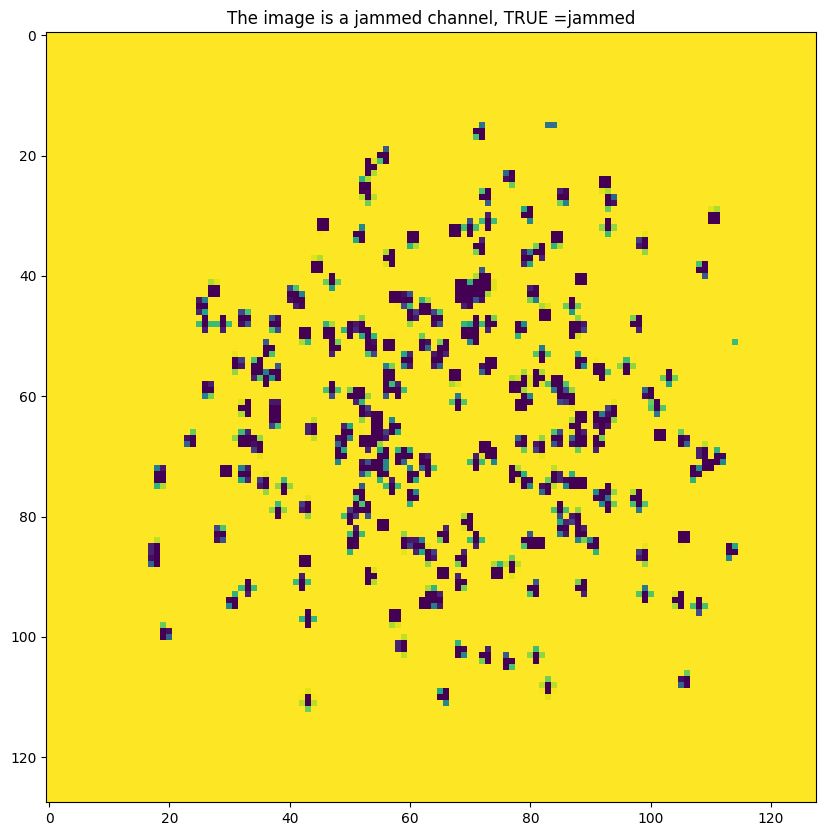

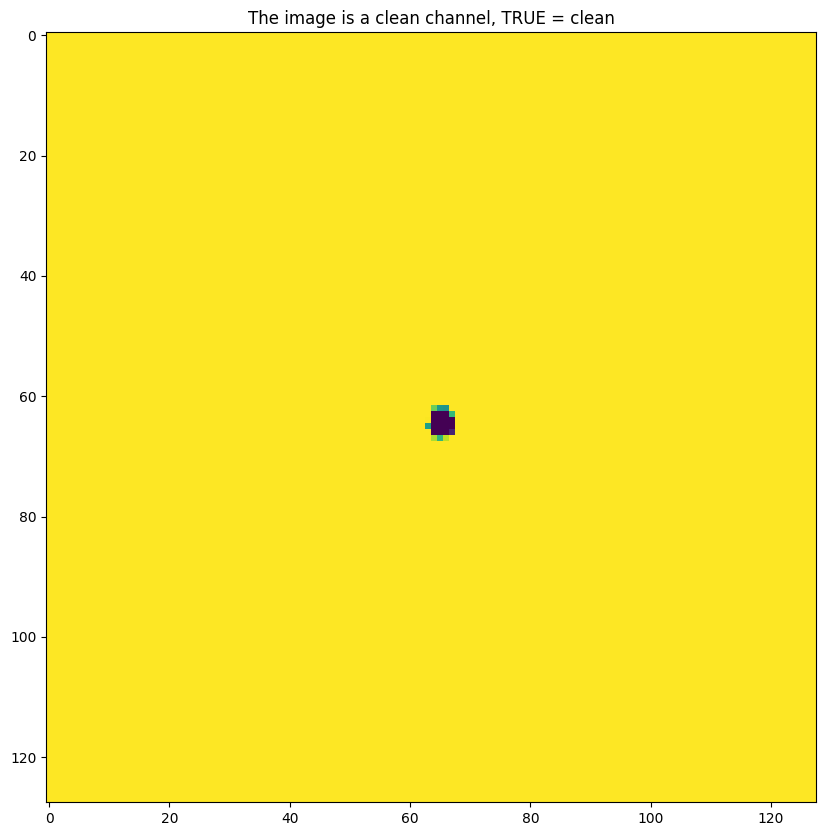

In [47]:
#anomaly verification for one image, just to see
num=random.randint(0,len(anomalies))
check_anomaly(anomalies[num], labels_anomalies[num],normal_values[0]+normal_values[1]) ## i set a chosen threshold

#same procedure as before
num=random.randint(0,len(val))
check_anomaly(val[num],labels_val[num],normal_values[0]+normal_values[1])

In [48]:
def compute_fn_fp(gt,pred):
  fp=0
  fn=0
  for i in range(len(gt)):
    if(gt[i]==0 and pred[i]==1):
      fp=fp+1
    if(gt[i]==1 and pred[i]==0):
      fn=fn+1
  return fn/len(gt),fp/len(gt)


In [51]:
values_th=np.arange(min_range_th,max_range_th,0.0002) ## range btw the min of the recon error and the maximum above all samples in the validation set
print(len(values_th))

90


In [52]:
errors=[]
for im in tqdm(test):
  img=im.reshape(1,128,128,1)/255.
  er=model.evaluate(img,img,batch_size=1)
  errors.append(er)

print(len(errors))

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0015


  0%|          | 2/800 [00:00<00:53, 15.04it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0185


  0%|          | 4/800 [00:00<00:52, 15.22it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


  1%|          | 6/800 [00:00<00:55, 14.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0083


  1%|          | 8/800 [00:00<00:53, 14.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0020


  1%|▏         | 10/800 [00:00<00:53, 14.82it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0078


  2%|▏         | 12/800 [00:00<00:51, 15.20it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0181


  2%|▏         | 14/800 [00:00<00:52, 15.03it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


  2%|▏         | 16/800 [00:01<00:54, 14.34it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0074


  2%|▏         | 18/800 [00:01<00:53, 14.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0020


  2%|▎         | 20/800 [00:01<00:54, 14.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0178


  3%|▎         | 22/800 [00:01<00:53, 14.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0069


  3%|▎         | 24/800 [00:01<00:51, 15.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0188


  3%|▎         | 26/800 [00:01<00:51, 15.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


  4%|▎         | 28/800 [00:01<00:50, 15.33it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0183


  4%|▍         | 30/800 [00:02<00:51, 14.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


  4%|▍         | 32/800 [00:02<00:52, 14.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0177


  4%|▍         | 34/800 [00:02<00:50, 15.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0186


  4%|▍         | 36/800 [00:02<00:51, 14.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0187


  5%|▍         | 38/800 [00:02<00:51, 14.84it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0021


  5%|▌         | 40/800 [00:02<00:52, 14.37it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0016


  5%|▌         | 42/800 [00:02<00:52, 14.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0180


  6%|▌         | 44/800 [00:02<00:53, 14.19it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0020


  6%|▌         | 46/800 [00:03<00:51, 14.69it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0076


  6%|▌         | 48/800 [00:03<00:50, 14.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


  6%|▋         | 50/800 [00:03<00:50, 14.79it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0175


  6%|▋         | 52/800 [00:03<00:49, 15.15it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0019


  7%|▋         | 54/800 [00:03<00:48, 15.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0075


  7%|▋         | 56/800 [00:03<00:51, 14.37it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0188


  7%|▋         | 58/800 [00:03<00:51, 14.37it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0081


  8%|▊         | 60/800 [00:04<00:50, 14.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0179


  8%|▊         | 62/800 [00:04<00:50, 14.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0190


  8%|▊         | 64/800 [00:04<00:50, 14.54it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0179


  8%|▊         | 66/800 [00:04<00:50, 14.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0186


  8%|▊         | 68/800 [00:04<00:48, 14.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0081


  9%|▉         | 70/800 [00:04<00:49, 14.82it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0079


  9%|▉         | 72/800 [00:04<00:48, 14.98it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0075


  9%|▉         | 74/800 [00:05<00:50, 14.27it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0084


 10%|▉         | 76/800 [00:05<00:51, 14.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0016


 10%|▉         | 78/800 [00:05<00:50, 14.31it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0080


 10%|█         | 80/800 [00:05<00:49, 14.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0017


 10%|█         | 82/800 [00:05<00:48, 14.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0074


 10%|█         | 84/800 [00:05<00:48, 14.90it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0075


 11%|█         | 86/800 [00:05<00:48, 14.72it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0020


 11%|█         | 88/800 [00:05<00:48, 14.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 11%|█▏        | 90/800 [00:06<00:48, 14.60it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0020


 12%|█▏        | 92/800 [00:06<01:27,  8.07it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0186


 12%|█▏        | 94/800 [00:06<01:16,  9.18it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0182


 12%|█▏        | 96/800 [00:06<01:10,  9.93it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0186


 12%|█▏        | 98/800 [00:07<01:05, 10.68it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0019


 12%|█▎        | 100/800 [00:07<01:02, 11.26it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0080


 13%|█▎        | 102/800 [00:07<01:00, 11.52it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0083


 13%|█▎        | 104/800 [00:07<01:01, 11.37it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0186


 13%|█▎        | 106/800 [00:07<01:04, 10.81it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0177


 14%|█▎        | 108/800 [00:08<01:07, 10.32it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0080


 14%|█▍        | 110/800 [00:08<01:08, 10.06it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0020


 14%|█▍        | 112/800 [00:08<01:07, 10.13it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0188


 14%|█▍        | 114/800 [00:08<01:05, 10.41it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0085


 14%|█▍        | 116/800 [00:08<01:06, 10.35it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0021


 15%|█▍        | 118/800 [00:08<01:04, 10.64it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0015


 15%|█▌        | 120/800 [00:09<01:06, 10.17it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0179


 15%|█▌        | 122/800 [00:09<01:10,  9.62it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0020


 15%|█▌        | 123/800 [00:09<01:10,  9.61it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0086


 16%|█▌        | 124/800 [00:09<01:12,  9.29it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0184


 16%|█▌        | 125/800 [00:09<01:12,  9.37it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0186


 16%|█▌        | 126/800 [00:09<01:11,  9.40it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0075


 16%|█▌        | 127/800 [00:09<01:12,  9.23it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0181


 16%|█▌        | 128/800 [00:10<01:11,  9.35it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0082


 16%|█▋        | 130/800 [00:10<01:04, 10.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


 16%|█▋        | 132/800 [00:10<00:57, 11.58it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0187


 17%|█▋        | 134/800 [00:10<00:55, 12.03it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0089


 17%|█▋        | 136/800 [00:10<00:53, 12.40it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0087


 17%|█▋        | 138/800 [00:10<00:51, 12.93it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0082


 18%|█▊        | 140/800 [00:10<00:51, 12.83it/s]

1/1 [==============================] - 0s 62ms/step - loss: 0.0183


 18%|█▊        | 142/800 [00:11<01:06,  9.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0019


 18%|█▊        | 144/800 [00:11<01:09,  9.40it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0183


 18%|█▊        | 146/800 [00:11<01:02, 10.47it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0078


 18%|█▊        | 148/800 [00:11<00:56, 11.52it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0080


 19%|█▉        | 150/800 [00:11<00:53, 12.08it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0187


 19%|█▉        | 152/800 [00:12<00:53, 12.08it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0185


 19%|█▉        | 154/800 [00:12<00:52, 12.32it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0181


 20%|█▉        | 156/800 [00:12<00:51, 12.40it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0186


 20%|█▉        | 158/800 [00:12<00:50, 12.71it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0085


 20%|██        | 160/800 [00:12<00:48, 13.16it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0179


 20%|██        | 162/800 [00:12<00:49, 12.97it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0179


 20%|██        | 164/800 [00:13<00:49, 12.91it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0086


 21%|██        | 166/800 [00:13<00:47, 13.27it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0182


 21%|██        | 168/800 [00:13<00:46, 13.47it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0020


 21%|██▏       | 170/800 [00:13<00:46, 13.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0177


 22%|██▏       | 172/800 [00:13<00:45, 13.82it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0015


 22%|██▏       | 174/800 [00:13<00:44, 14.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


 22%|██▏       | 176/800 [00:13<00:44, 14.08it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0081


 22%|██▏       | 178/800 [00:14<00:42, 14.57it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0182


 22%|██▎       | 180/800 [00:14<00:41, 14.79it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0186


 23%|██▎       | 182/800 [00:14<00:42, 14.47it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0015


 23%|██▎       | 184/800 [00:14<00:44, 13.97it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0083


 23%|██▎       | 186/800 [00:14<00:45, 13.36it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0182


 24%|██▎       | 188/800 [00:14<00:45, 13.52it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0179


 24%|██▍       | 190/800 [00:14<00:45, 13.50it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0180


 24%|██▍       | 192/800 [00:15<00:45, 13.34it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0181


 24%|██▍       | 194/800 [00:15<00:45, 13.36it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0188


 24%|██▍       | 196/800 [00:15<00:46, 13.10it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0076


 25%|██▍       | 198/800 [00:15<00:47, 12.75it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0183


 25%|██▌       | 200/800 [00:15<00:47, 12.68it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0186


 25%|██▌       | 202/800 [00:15<00:46, 12.86it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0183


 26%|██▌       | 204/800 [00:15<00:45, 13.15it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0185


 26%|██▌       | 206/800 [00:16<00:43, 13.55it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0187


 26%|██▌       | 208/800 [00:16<00:45, 13.15it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0184


 26%|██▋       | 210/800 [00:16<00:45, 13.11it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0020


 26%|██▋       | 212/800 [00:16<00:43, 13.50it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0015


 27%|██▋       | 214/800 [00:16<00:43, 13.53it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0186


 27%|██▋       | 216/800 [00:16<00:42, 13.75it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0015


 27%|██▋       | 218/800 [00:16<00:42, 13.78it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0015


 28%|██▊       | 220/800 [00:17<00:42, 13.76it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0064


 28%|██▊       | 222/800 [00:17<00:42, 13.61it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0181


 28%|██▊       | 224/800 [00:17<00:41, 13.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0089


 28%|██▊       | 226/800 [00:17<00:40, 14.03it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0021


 28%|██▊       | 228/800 [00:17<00:40, 14.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 29%|██▉       | 230/800 [00:17<00:39, 14.33it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0186


 29%|██▉       | 232/800 [00:17<00:39, 14.56it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0079


 29%|██▉       | 234/800 [00:18<00:38, 14.69it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0187


 30%|██▉       | 236/800 [00:18<00:40, 13.92it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0186


 30%|██▉       | 238/800 [00:18<00:40, 14.03it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0181


 30%|███       | 240/800 [00:18<00:40, 13.92it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0076


 30%|███       | 242/800 [00:18<00:40, 13.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0176


 30%|███       | 244/800 [00:18<00:39, 13.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0179


 31%|███       | 246/800 [00:18<00:39, 13.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


 31%|███       | 248/800 [00:19<00:39, 13.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0189


 31%|███▏      | 250/800 [00:19<00:39, 13.80it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0178


 32%|███▏      | 252/800 [00:19<00:40, 13.51it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0080


 32%|███▏      | 254/800 [00:19<00:39, 13.88it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


 32%|███▏      | 256/800 [00:19<00:38, 14.13it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0182


 32%|███▏      | 258/800 [00:19<00:37, 14.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0021


 32%|███▎      | 260/800 [00:19<00:37, 14.32it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0015


 33%|███▎      | 262/800 [00:20<00:39, 13.50it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0083


 33%|███▎      | 264/800 [00:20<00:43, 12.28it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0081


 33%|███▎      | 266/800 [00:20<00:45, 11.66it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0186


 34%|███▎      | 268/800 [00:20<00:45, 11.76it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0019


 34%|███▍      | 270/800 [00:20<00:45, 11.59it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0020


 34%|███▍      | 272/800 [00:21<00:45, 11.71it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0080


 34%|███▍      | 274/800 [00:21<00:43, 12.05it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0182


 34%|███▍      | 276/800 [00:21<00:44, 11.73it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0019


 35%|███▍      | 278/800 [00:21<00:46, 11.13it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0015


 35%|███▌      | 280/800 [00:21<00:46, 11.19it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0191


 35%|███▌      | 282/800 [00:21<00:47, 10.89it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0077


 36%|███▌      | 284/800 [00:22<00:46, 11.09it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0185


 36%|███▌      | 286/800 [00:22<00:46, 10.94it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0080


 36%|███▌      | 288/800 [00:22<00:49, 10.27it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0087


 36%|███▋      | 290/800 [00:22<00:49, 10.40it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0015


 36%|███▋      | 292/800 [00:22<00:48, 10.45it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0187


 37%|███▋      | 294/800 [00:23<00:46, 10.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 37%|███▋      | 296/800 [00:23<00:43, 11.58it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0088


 37%|███▋      | 298/800 [00:23<00:41, 12.16it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 38%|███▊      | 300/800 [00:23<00:39, 12.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0084


 38%|███▊      | 302/800 [00:23<00:37, 13.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


 38%|███▊      | 304/800 [00:23<00:36, 13.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 38%|███▊      | 306/800 [00:23<00:35, 13.75it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0015


 38%|███▊      | 308/800 [00:24<00:34, 14.11it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0162


 39%|███▉      | 310/800 [00:24<00:33, 14.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


 39%|███▉      | 312/800 [00:24<00:33, 14.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


 39%|███▉      | 314/800 [00:24<00:32, 14.80it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 40%|███▉      | 316/800 [00:24<00:32, 14.73it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 40%|███▉      | 318/800 [00:24<00:32, 14.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0084


 40%|████      | 320/800 [00:24<00:32, 14.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0185


 40%|████      | 322/800 [00:25<00:34, 14.03it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0177


 40%|████      | 324/800 [00:25<00:33, 14.29it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0187


 41%|████      | 326/800 [00:25<00:32, 14.48it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0180


 41%|████      | 328/800 [00:25<00:33, 14.16it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0074


 41%|████▏     | 330/800 [00:25<00:34, 13.54it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0079


 42%|████▏     | 332/800 [00:25<00:34, 13.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0178


 42%|████▏     | 334/800 [00:25<00:34, 13.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0020


 42%|████▏     | 336/800 [00:26<00:33, 13.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0020


 42%|████▏     | 338/800 [00:26<00:33, 13.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0185


 42%|████▎     | 340/800 [00:26<00:33, 13.85it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0019


 43%|████▎     | 342/800 [00:26<00:31, 14.39it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0178


 43%|████▎     | 344/800 [00:26<00:32, 14.11it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0188


 43%|████▎     | 346/800 [00:26<00:32, 13.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 44%|████▎     | 348/800 [00:26<00:33, 13.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0075


 44%|████▍     | 350/800 [00:27<00:32, 13.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


 44%|████▍     | 352/800 [00:27<00:33, 13.41it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


 44%|████▍     | 354/800 [00:27<00:32, 13.59it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


 44%|████▍     | 356/800 [00:27<00:32, 13.73it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0186


 45%|████▍     | 358/800 [00:27<00:32, 13.77it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


 45%|████▌     | 360/800 [00:27<00:31, 13.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0080


 45%|████▌     | 362/800 [00:27<00:30, 14.16it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0088


 46%|████▌     | 364/800 [00:28<00:30, 14.52it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0188


 46%|████▌     | 366/800 [00:28<00:30, 14.42it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0078


 46%|████▌     | 368/800 [00:28<00:30, 14.25it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0180


 46%|████▋     | 370/800 [00:28<00:30, 14.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0082


 46%|████▋     | 372/800 [00:28<00:30, 13.82it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0084


 47%|████▋     | 374/800 [00:28<00:31, 13.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 47%|████▋     | 376/800 [00:28<00:30, 13.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0176


 47%|████▋     | 378/800 [00:29<00:30, 13.98it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0020


 48%|████▊     | 380/800 [00:29<00:29, 14.13it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0182


 48%|████▊     | 382/800 [00:29<00:29, 14.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


 48%|████▊     | 384/800 [00:29<00:29, 14.31it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0188


 48%|████▊     | 386/800 [00:29<00:29, 14.28it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0016


 48%|████▊     | 388/800 [00:29<00:29, 14.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


 49%|████▉     | 390/800 [00:29<00:29, 14.13it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


 49%|████▉     | 392/800 [00:30<00:29, 13.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


 49%|████▉     | 394/800 [00:30<00:28, 14.08it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0020


 50%|████▉     | 396/800 [00:30<00:28, 14.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0021


 50%|████▉     | 398/800 [00:30<00:28, 14.08it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0016


 50%|█████     | 400/800 [00:30<00:28, 14.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0019


 50%|█████     | 402/800 [00:30<00:27, 14.31it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0138


 50%|█████     | 404/800 [00:30<00:27, 14.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 51%|█████     | 406/800 [00:31<00:28, 14.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0016


 51%|█████     | 408/800 [00:31<00:28, 13.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0084


 51%|█████▏    | 410/800 [00:31<00:28, 13.56it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0081


 52%|█████▏    | 412/800 [00:31<00:31, 12.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0193


 52%|█████▏    | 414/800 [00:31<00:30, 12.59it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0192


 52%|█████▏    | 416/800 [00:31<00:29, 13.18it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0180


 52%|█████▏    | 418/800 [00:31<00:28, 13.57it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0182


 52%|█████▎    | 420/800 [00:32<00:27, 13.72it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0180


 53%|█████▎    | 422/800 [00:32<00:27, 13.50it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0177


 53%|█████▎    | 424/800 [00:32<00:28, 13.42it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0185


 53%|█████▎    | 426/800 [00:32<00:27, 13.40it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0084


 54%|█████▎    | 428/800 [00:32<00:28, 13.07it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0182


 54%|█████▍    | 430/800 [00:32<00:27, 13.27it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0086


 54%|█████▍    | 432/800 [00:33<00:28, 13.03it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0180


 54%|█████▍    | 434/800 [00:33<00:30, 11.87it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0086


 55%|█████▍    | 436/800 [00:33<00:32, 11.36it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0189


 55%|█████▍    | 438/800 [00:33<00:33, 10.87it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0019


 55%|█████▌    | 440/800 [00:33<00:34, 10.47it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0021


 55%|█████▌    | 442/800 [00:34<00:34, 10.42it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0176


 56%|█████▌    | 444/800 [00:34<00:34, 10.42it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0079


 56%|█████▌    | 446/800 [00:34<00:33, 10.53it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0089


 56%|█████▌    | 448/800 [00:34<00:33, 10.39it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0078


 56%|█████▋    | 450/800 [00:34<00:35,  9.97it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0175


 56%|█████▋    | 452/800 [00:35<00:35,  9.77it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0084


 57%|█████▋    | 453/800 [00:35<00:35,  9.77it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0175


 57%|█████▋    | 455/800 [00:35<00:34, 10.03it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0178


 57%|█████▋    | 457/800 [00:35<00:34, 10.08it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0086


 57%|█████▋    | 459/800 [00:35<00:33, 10.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0076


 58%|█████▊    | 461/800 [00:35<00:30, 10.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0075


 58%|█████▊    | 463/800 [00:36<00:28, 11.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0180


 58%|█████▊    | 465/800 [00:36<00:26, 12.54it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 58%|█████▊    | 467/800 [00:36<00:25, 13.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


 59%|█████▊    | 469/800 [00:36<00:24, 13.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0081


 59%|█████▉    | 471/800 [00:36<00:23, 13.74it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0181


 59%|█████▉    | 473/800 [00:36<00:23, 14.05it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0182


 59%|█████▉    | 475/800 [00:36<00:23, 13.91it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0085


 60%|█████▉    | 477/800 [00:36<00:23, 13.83it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0080


 60%|█████▉    | 479/800 [00:37<00:23, 13.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


 60%|██████    | 481/800 [00:37<00:23, 13.68it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0182


 60%|██████    | 483/800 [00:37<00:22, 13.87it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0021


 61%|██████    | 485/800 [00:37<00:22, 13.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0079


 61%|██████    | 487/800 [00:37<00:22, 13.94it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0081


 61%|██████    | 489/800 [00:37<00:22, 13.87it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0191


 61%|██████▏   | 491/800 [00:37<00:21, 14.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0083


 62%|██████▏   | 493/800 [00:38<00:21, 14.19it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0186


 62%|██████▏   | 495/800 [00:38<00:21, 14.30it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0181


 62%|██████▏   | 497/800 [00:38<00:22, 13.76it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0185


 62%|██████▏   | 499/800 [00:38<00:21, 13.87it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


 63%|██████▎   | 501/800 [00:38<00:21, 13.94it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0020


 63%|██████▎   | 503/800 [00:38<00:20, 14.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0087


 63%|██████▎   | 505/800 [00:38<00:20, 14.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0182


 63%|██████▎   | 507/800 [00:39<00:20, 14.12it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 64%|██████▎   | 509/800 [00:39<00:20, 13.99it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0015


 64%|██████▍   | 511/800 [00:39<00:20, 13.90it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0015


 64%|██████▍   | 513/800 [00:39<00:20, 14.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0077


 64%|██████▍   | 515/800 [00:39<00:19, 14.41it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


 65%|██████▍   | 517/800 [00:39<00:20, 13.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 65%|██████▍   | 519/800 [00:39<00:19, 14.09it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


 65%|██████▌   | 521/800 [00:40<00:19, 14.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0079


 65%|██████▌   | 523/800 [00:40<00:19, 14.55it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0188


 66%|██████▌   | 525/800 [00:40<00:18, 14.81it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0089


 66%|██████▌   | 527/800 [00:40<00:18, 14.58it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0015


 66%|██████▌   | 529/800 [00:40<00:18, 14.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0020


 66%|██████▋   | 531/800 [00:40<00:18, 14.40it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0073


 67%|██████▋   | 533/800 [00:40<00:19, 13.86it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0015


 67%|██████▋   | 535/800 [00:41<00:19, 13.71it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0015


 67%|██████▋   | 537/800 [00:41<00:19, 13.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0184


 67%|██████▋   | 539/800 [00:41<00:19, 13.46it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0020


 68%|██████▊   | 541/800 [00:41<00:18, 13.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0019


 68%|██████▊   | 543/800 [00:41<00:18, 13.55it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0085


 68%|██████▊   | 545/800 [00:41<00:18, 13.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 68%|██████▊   | 547/800 [00:41<00:18, 13.82it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0015


 69%|██████▊   | 549/800 [00:42<00:18, 13.93it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0180


 69%|██████▉   | 551/800 [00:42<00:17, 13.87it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0082


 69%|██████▉   | 553/800 [00:42<00:18, 13.26it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0181


 69%|██████▉   | 555/800 [00:42<00:18, 13.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0186


 70%|██████▉   | 557/800 [00:42<00:18, 13.22it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0085


 70%|██████▉   | 559/800 [00:42<00:17, 13.43it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0181


 70%|███████   | 561/800 [00:43<00:18, 12.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


 70%|███████   | 563/800 [00:43<00:18, 12.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 71%|███████   | 565/800 [00:43<00:17, 13.25it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0182


 71%|███████   | 567/800 [00:43<00:17, 13.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0185


 71%|███████   | 569/800 [00:43<00:17, 12.95it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0015


 71%|███████▏  | 571/800 [00:43<00:17, 13.08it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0188


 72%|███████▏  | 573/800 [00:43<00:17, 13.13it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0080


 72%|███████▏  | 575/800 [00:44<00:16, 13.60it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


 72%|███████▏  | 577/800 [00:44<00:16, 13.65it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 72%|███████▏  | 579/800 [00:44<00:16, 13.35it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0080


 73%|███████▎  | 581/800 [00:44<00:16, 13.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0085


 73%|███████▎  | 583/800 [00:44<00:15, 13.72it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0020


 73%|███████▎  | 585/800 [00:44<00:15, 13.95it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0184


 73%|███████▎  | 587/800 [00:44<00:15, 13.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0183


 74%|███████▎  | 589/800 [00:45<00:16, 13.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 74%|███████▍  | 591/800 [00:45<00:15, 13.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0021


 74%|███████▍  | 593/800 [00:45<00:15, 13.24it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0021


 74%|███████▍  | 595/800 [00:45<00:15, 13.03it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0179


 75%|███████▍  | 597/800 [00:45<00:16, 12.52it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0019


 75%|███████▍  | 599/800 [00:45<00:17, 11.66it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0015


 75%|███████▌  | 601/800 [00:46<00:18, 11.01it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0077


 75%|███████▌  | 603/800 [00:46<00:18, 10.47it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0178


 76%|███████▌  | 605/800 [00:46<00:19, 10.25it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0187


 76%|███████▌  | 607/800 [00:46<00:18, 10.22it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0086


 76%|███████▌  | 609/800 [00:46<00:18, 10.07it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0019


 76%|███████▋  | 611/800 [00:47<00:19,  9.64it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0183


 77%|███████▋  | 613/800 [00:47<00:19,  9.77it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0015


 77%|███████▋  | 614/800 [00:47<00:19,  9.66it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0190


 77%|███████▋  | 616/800 [00:47<00:17, 10.30it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0184


 77%|███████▋  | 618/800 [00:47<00:17, 10.68it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0180


 78%|███████▊  | 620/800 [00:48<00:16, 11.09it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0186


 78%|███████▊  | 622/800 [00:48<00:17,  9.99it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0076


 78%|███████▊  | 624/800 [00:48<00:17,  9.97it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0183


 78%|███████▊  | 626/800 [00:48<00:17, 10.19it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0079


 78%|███████▊  | 628/800 [00:48<00:16, 10.19it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0079


 79%|███████▉  | 630/800 [00:49<00:15, 11.00it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0188


 79%|███████▉  | 632/800 [00:49<00:14, 11.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0020


 79%|███████▉  | 634/800 [00:49<00:13, 11.87it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0087


 80%|███████▉  | 636/800 [00:49<00:13, 12.47it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0015


 80%|███████▉  | 638/800 [00:49<00:12, 12.59it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0176


 80%|████████  | 640/800 [00:49<00:12, 13.13it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0016


 80%|████████  | 642/800 [00:49<00:11, 13.38it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0177


 80%|████████  | 644/800 [00:50<00:11, 13.43it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0021


 81%|████████  | 646/800 [00:50<00:11, 13.43it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0179


 81%|████████  | 648/800 [00:50<00:11, 13.58it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0184


 81%|████████▏ | 650/800 [00:50<00:11, 13.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0181


 82%|████████▏ | 652/800 [00:50<00:10, 13.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0181


 82%|████████▏ | 654/800 [00:50<00:10, 13.64it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0015


 82%|████████▏ | 656/800 [00:50<00:10, 13.48it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0077


 82%|████████▏ | 658/800 [00:51<00:10, 13.54it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0015


 82%|████████▎ | 660/800 [00:51<00:10, 13.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


 83%|████████▎ | 662/800 [00:51<00:10, 13.30it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0079


 83%|████████▎ | 664/800 [00:51<00:09, 13.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 83%|████████▎ | 666/800 [00:51<00:09, 13.44it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 84%|████████▎ | 668/800 [00:51<00:09, 13.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0187


 84%|████████▍ | 670/800 [00:51<00:09, 13.81it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 84%|████████▍ | 672/800 [00:52<00:09, 13.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 84%|████████▍ | 674/800 [00:52<00:08, 14.02it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0186


 84%|████████▍ | 676/800 [00:52<00:08, 13.92it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0021


 85%|████████▍ | 678/800 [00:52<00:08, 13.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0083


 85%|████████▌ | 680/800 [00:52<00:08, 13.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


 85%|████████▌ | 682/800 [00:52<00:08, 13.82it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0085


 86%|████████▌ | 684/800 [00:53<00:09, 12.58it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 86%|████████▌ | 686/800 [00:53<00:08, 12.98it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0186


 86%|████████▌ | 688/800 [00:53<00:08, 12.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 86%|████████▋ | 690/800 [00:53<00:08, 13.19it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0081


 86%|████████▋ | 692/800 [00:53<00:07, 13.69it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0187


 87%|████████▋ | 694/800 [00:53<00:07, 13.91it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0184


 87%|████████▋ | 696/800 [00:53<00:07, 13.76it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0186


 87%|████████▋ | 698/800 [00:54<00:07, 13.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


 88%|████████▊ | 700/800 [00:54<00:07, 13.35it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0182


 88%|████████▊ | 702/800 [00:54<00:07, 13.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0083


 88%|████████▊ | 704/800 [00:54<00:07, 13.11it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0077


 88%|████████▊ | 706/800 [00:54<00:07, 13.16it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0015


 88%|████████▊ | 708/800 [00:54<00:06, 13.29it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0020


 89%|████████▉ | 710/800 [00:54<00:06, 13.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0020


 89%|████████▉ | 712/800 [00:55<00:06, 13.43it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0183


 89%|████████▉ | 714/800 [00:55<00:06, 13.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0022


 90%|████████▉ | 716/800 [00:55<00:06, 13.54it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0182


 90%|████████▉ | 718/800 [00:55<00:06, 13.45it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 90%|█████████ | 720/800 [00:55<00:05, 13.50it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0021


 90%|█████████ | 722/800 [00:55<00:05, 13.54it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0084


 90%|█████████ | 724/800 [00:55<00:05, 13.16it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0186


 91%|█████████ | 726/800 [00:56<00:05, 13.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0015


 91%|█████████ | 728/800 [00:56<00:05, 13.68it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0080


 91%|█████████▏| 730/800 [00:56<00:05, 13.56it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0186


 92%|█████████▏| 732/800 [00:56<00:05, 13.48it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0021


 92%|█████████▏| 734/800 [00:56<00:04, 13.64it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0015


 92%|█████████▏| 736/800 [00:56<00:04, 13.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0020


 92%|█████████▏| 738/800 [00:56<00:04, 13.87it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


 92%|█████████▎| 740/800 [00:57<00:04, 13.96it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0019


 93%|█████████▎| 742/800 [00:57<00:04, 13.91it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0182


 93%|█████████▎| 744/800 [00:57<00:04, 13.69it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0180


 93%|█████████▎| 746/800 [00:57<00:03, 13.59it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0019


 94%|█████████▎| 748/800 [00:57<00:03, 13.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0080


 94%|█████████▍| 750/800 [00:57<00:03, 13.99it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


 94%|█████████▍| 752/800 [00:57<00:03, 14.16it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0079


 94%|█████████▍| 754/800 [00:58<00:03, 14.14it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0066


 94%|█████████▍| 756/800 [00:58<00:03, 14.32it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0087


 95%|█████████▍| 758/800 [00:58<00:02, 14.18it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0178


 95%|█████████▌| 760/800 [00:58<00:02, 14.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0086


 95%|█████████▌| 762/800 [00:58<00:02, 14.39it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0182


 96%|█████████▌| 764/800 [00:58<00:02, 14.61it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0084


 96%|█████████▌| 766/800 [00:58<00:02, 13.34it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0177


 96%|█████████▌| 768/800 [00:59<00:02, 12.60it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0020


 96%|█████████▋| 770/800 [00:59<00:02, 12.00it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0176


 96%|█████████▋| 772/800 [00:59<00:02, 11.74it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0186


 97%|█████████▋| 774/800 [00:59<00:02, 11.24it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0084


 97%|█████████▋| 776/800 [00:59<00:02, 10.98it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0084


 97%|█████████▋| 778/800 [01:00<00:02, 10.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0015


 98%|█████████▊| 780/800 [01:00<00:01, 11.02it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0020


 98%|█████████▊| 782/800 [01:00<00:01, 11.19it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0180


 98%|█████████▊| 784/800 [01:00<00:01, 11.27it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0084


 98%|█████████▊| 786/800 [01:00<00:01, 11.45it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0080


 98%|█████████▊| 788/800 [01:00<00:01, 11.24it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0015


 99%|█████████▉| 790/800 [01:01<00:00, 11.08it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0182


 99%|█████████▉| 792/800 [01:01<00:00, 11.33it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0185


 99%|█████████▉| 794/800 [01:01<00:00, 10.99it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0016


100%|█████████▉| 796/800 [01:01<00:00, 11.24it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0081


100%|█████████▉| 798/800 [01:01<00:00, 11.62it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0015


100%|██████████| 800/800 [01:02<00:00, 12.90it/s]

800


In [53]:
def compute_predictions(th,errors):
  pred=[]
  for err in errors:
    if(err>th):
      pred.append(1)
    else:
      pred.append(0)
  return pred

In [54]:
false_neg=[]
false_pos=[]
for t in values_th:
  predictions=compute_predictions(t,errors)
  probs=compute_fn_fp(labels_test,predictions)
  false_neg.append(probs[0])
  false_pos.append(probs[1])

In [55]:
print(false_neg)
print(false_pos)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00125, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.00375, 0.00375, 0.00375, 0.00375, 0.005, 0.0075, 0.01375, 0.03875, 0.08375, 0.1775, 0.275, 0.35375, 0.43375, 0.47, 0.49, 0.49875]
[0.5, 0.375, 0.3625, 0.26125, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.24875, 0.2475, 0.24625, 0.245, 0.24375, 0.22625, 0.20625, 0.1675, 0.12375, 0.08375, 0.04625, 0.0175, 0.00625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

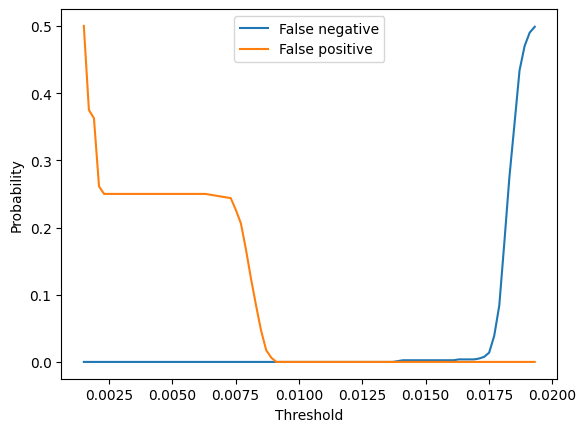

In [56]:
plt.plot(values_th,false_neg,label="False negative")
plt.plot(values_th,false_pos,label="False positive")
plt.xlabel("Threshold")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [57]:
pred=[]
for im in tqdm(test):
    
    img= im.reshape(1,128,128,1)/255.
    error=model.evaluate(img,img,batch_size=1)
    if(error<normal_values[0]+normal_values[1]):
      pred.append(0)
    else:
      pred.append(1)

correct=np.array(pred)==np.array(labels_test)

## make predictions on the test set and create a mask where we can see if the prediction was correct for a given threshold

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


  0%|          | 2/800 [00:00<00:50, 15.80it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


  0%|          | 4/800 [00:00<00:51, 15.31it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0182


  1%|          | 6/800 [00:00<00:53, 14.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0083


  1%|          | 8/800 [00:00<00:50, 15.56it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0020


  1%|▏         | 10/800 [00:00<00:51, 15.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0078


  2%|▏         | 12/800 [00:00<00:50, 15.66it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


  2%|▏         | 14/800 [00:00<00:50, 15.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0015


  2%|▏         | 16/800 [00:01<00:49, 15.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0074


  2%|▏         | 18/800 [00:01<00:51, 15.24it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0020


  2%|▎         | 20/800 [00:01<00:50, 15.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0178


  3%|▎         | 22/800 [00:01<00:50, 15.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0069


  3%|▎         | 24/800 [00:01<00:50, 15.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0188


  3%|▎         | 26/800 [00:01<00:49, 15.61it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0182


  4%|▎         | 28/800 [00:01<00:49, 15.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0183


  4%|▍         | 30/800 [00:01<00:50, 15.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0015


  4%|▍         | 32/800 [00:02<00:51, 14.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0177


  4%|▍         | 34/800 [00:02<00:51, 14.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


  4%|▍         | 36/800 [00:02<00:51, 14.89it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


  5%|▍         | 38/800 [00:02<00:50, 15.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0021


  5%|▌         | 40/800 [00:02<00:50, 15.14it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0016


  5%|▌         | 42/800 [00:02<00:49, 15.36it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0180


  6%|▌         | 44/800 [00:02<00:48, 15.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0020


  6%|▌         | 46/800 [00:02<00:47, 15.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0076


  6%|▌         | 48/800 [00:03<00:47, 15.84it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0015


  6%|▋         | 50/800 [00:03<00:47, 15.81it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0175


  6%|▋         | 52/800 [00:03<00:48, 15.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0019


  7%|▋         | 54/800 [00:03<00:49, 15.14it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0075


  7%|▋         | 56/800 [00:03<00:48, 15.40it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0188


  7%|▋         | 58/800 [00:03<00:49, 14.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0081


  8%|▊         | 60/800 [00:03<00:49, 14.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0179


  8%|▊         | 62/800 [00:04<00:48, 15.22it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0190


  8%|▊         | 64/800 [00:04<00:46, 15.67it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0179


  8%|▊         | 66/800 [00:04<00:49, 14.85it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0186


  8%|▊         | 68/800 [00:04<00:48, 15.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0081


  9%|▉         | 70/800 [00:04<00:47, 15.21it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0079


  9%|▉         | 72/800 [00:04<00:46, 15.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0075


  9%|▉         | 74/800 [00:04<00:47, 15.40it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0084


 10%|▉         | 76/800 [00:04<00:49, 14.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0016


 10%|▉         | 78/800 [00:05<00:48, 14.74it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0080


 10%|█         | 80/800 [00:05<00:47, 15.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0017


 10%|█         | 82/800 [00:05<00:48, 14.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0074


 10%|█         | 84/800 [00:05<00:47, 15.22it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0075


 11%|█         | 86/800 [00:05<00:46, 15.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0020


 11%|█         | 88/800 [00:05<00:46, 15.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0015


 11%|█▏        | 90/800 [00:05<00:45, 15.56it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0020


 12%|█▏        | 92/800 [00:06<00:44, 15.97it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0186


 12%|█▏        | 94/800 [00:06<00:43, 16.06it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0182


 12%|█▏        | 96/800 [00:06<00:45, 15.49it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0186


 12%|█▏        | 98/800 [00:06<00:47, 14.67it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0019


 12%|█▎        | 100/800 [00:06<00:46, 14.97it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0080


 13%|█▎        | 102/800 [00:06<00:45, 15.32it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0083


 13%|█▎        | 104/800 [00:06<00:45, 15.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 13%|█▎        | 106/800 [00:06<00:45, 15.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0177


 14%|█▎        | 108/800 [00:07<00:45, 15.32it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0080


 14%|█▍        | 110/800 [00:07<00:44, 15.54it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0020


 14%|█▍        | 112/800 [00:07<00:44, 15.37it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0188


 14%|█▍        | 114/800 [00:07<00:44, 15.56it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0085


 14%|█▍        | 116/800 [00:07<00:43, 15.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0021


 15%|█▍        | 118/800 [00:07<00:44, 15.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


 15%|█▌        | 120/800 [00:07<00:43, 15.48it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0179


 15%|█▌        | 122/800 [00:07<00:43, 15.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0086


 16%|█▌        | 124/800 [00:08<00:43, 15.40it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0186


 16%|█▌        | 126/800 [00:08<00:44, 15.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


 16%|█▌        | 128/800 [00:08<00:44, 15.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0082


 16%|█▋        | 130/800 [00:08<00:43, 15.47it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0180


 16%|█▋        | 132/800 [00:08<00:43, 15.53it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0187


 17%|█▋        | 134/800 [00:08<00:42, 15.55it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0089


 17%|█▋        | 136/800 [00:08<00:43, 15.14it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0087


 17%|█▋        | 138/800 [00:08<00:42, 15.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0082


 18%|█▊        | 140/800 [00:09<00:42, 15.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0183


 18%|█▊        | 142/800 [00:09<00:41, 15.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0019


 18%|█▊        | 144/800 [00:09<00:41, 15.75it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0183


 18%|█▊        | 146/800 [00:09<00:45, 14.42it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0078


 18%|█▊        | 148/800 [00:09<00:48, 13.36it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0080


 19%|█▉        | 150/800 [00:09<00:51, 12.66it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0187


 19%|█▉        | 152/800 [00:10<00:52, 12.37it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0185


 19%|█▉        | 154/800 [00:10<01:33,  6.92it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0087


 19%|█▉        | 155/800 [00:10<01:29,  7.24it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0187


 20%|█▉        | 157/800 [00:10<01:19,  8.10it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0186


 20%|█▉        | 158/800 [00:11<01:16,  8.40it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0186


 20%|█▉        | 159/800 [00:11<01:14,  8.58it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0015


 20%|██        | 161/800 [00:11<01:09,  9.22it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0179


 20%|██        | 162/800 [00:11<01:09,  9.13it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0179


 20%|██        | 164/800 [00:11<01:07,  9.40it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0181


 21%|██        | 165/800 [00:11<01:06,  9.49it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0086


 21%|██        | 166/800 [00:11<01:06,  9.56it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0182


 21%|██        | 168/800 [00:12<01:01, 10.21it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0020


 21%|██▏       | 170/800 [00:12<00:57, 11.02it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0177


 22%|██▏       | 172/800 [00:12<00:53, 11.83it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0015


 22%|██▏       | 174/800 [00:12<00:51, 12.21it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0183


 22%|██▏       | 176/800 [00:12<00:50, 12.41it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0081


 22%|██▏       | 178/800 [00:12<00:50, 12.42it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0182


 22%|██▎       | 180/800 [00:12<00:50, 12.31it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0186


 23%|██▎       | 182/800 [00:13<00:48, 12.64it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0015


 23%|██▎       | 184/800 [00:13<00:47, 13.02it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0083


 23%|██▎       | 186/800 [00:13<00:45, 13.54it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0182


 24%|██▎       | 188/800 [00:13<00:46, 13.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


 24%|██▍       | 190/800 [00:13<00:45, 13.29it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0180


 24%|██▍       | 192/800 [00:13<00:45, 13.32it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0181


 24%|██▍       | 194/800 [00:14<00:45, 13.34it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0188


 24%|██▍       | 196/800 [00:14<00:46, 12.99it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0076


 25%|██▍       | 198/800 [00:14<00:45, 13.13it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0183


 25%|██▌       | 200/800 [00:14<00:45, 13.16it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0186


 25%|██▌       | 202/800 [00:14<00:46, 12.92it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0183


 26%|██▌       | 204/800 [00:14<00:45, 12.98it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0185


 26%|██▌       | 206/800 [00:14<00:44, 13.47it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0187


 26%|██▌       | 208/800 [00:15<00:43, 13.75it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0184


 26%|██▋       | 210/800 [00:15<00:43, 13.64it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0020


 26%|██▋       | 212/800 [00:15<00:44, 13.32it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0015


 27%|██▋       | 214/800 [00:15<00:42, 13.77it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0186


 27%|██▋       | 216/800 [00:15<00:43, 13.42it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0015


 27%|██▋       | 218/800 [00:15<00:43, 13.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


 28%|██▊       | 220/800 [00:15<00:42, 13.80it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0064


 28%|██▊       | 222/800 [00:16<00:42, 13.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


 28%|██▊       | 224/800 [00:16<00:43, 13.35it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0089


 28%|██▊       | 226/800 [00:16<00:41, 13.90it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0021


 28%|██▊       | 228/800 [00:16<00:41, 13.89it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0184


 29%|██▉       | 230/800 [00:16<00:40, 13.93it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0186


 29%|██▉       | 232/800 [00:16<00:42, 13.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0079


 29%|██▉       | 234/800 [00:16<00:39, 14.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 30%|██▉       | 236/800 [00:17<00:39, 14.44it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0186


 30%|██▉       | 238/800 [00:17<00:40, 13.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


 30%|███       | 240/800 [00:17<00:39, 14.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0076


 30%|███       | 242/800 [00:17<00:38, 14.46it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0176


 30%|███       | 244/800 [00:17<00:38, 14.44it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0179


 31%|███       | 246/800 [00:17<00:39, 14.02it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0182


 31%|███       | 248/800 [00:17<00:38, 14.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0189


 31%|███▏      | 250/800 [00:18<00:37, 14.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0178


 32%|███▏      | 252/800 [00:18<00:37, 14.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0080


 32%|███▏      | 254/800 [00:18<00:37, 14.54it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0179


 32%|███▏      | 256/800 [00:18<00:36, 14.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0182


 32%|███▏      | 258/800 [00:18<00:36, 14.92it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0021


 32%|███▎      | 260/800 [00:18<00:37, 14.37it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0015


 33%|███▎      | 262/800 [00:18<00:36, 14.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0083


 33%|███▎      | 264/800 [00:19<00:36, 14.56it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0081


 33%|███▎      | 266/800 [00:19<00:36, 14.66it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 34%|███▎      | 268/800 [00:19<00:35, 15.03it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0019


 34%|███▍      | 270/800 [00:19<00:34, 15.52it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0020


 34%|███▍      | 272/800 [00:19<00:36, 14.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0080


 34%|███▍      | 274/800 [00:19<00:35, 14.73it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0182


 34%|███▍      | 276/800 [00:19<00:35, 14.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0019


 35%|███▍      | 278/800 [00:19<00:35, 14.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0015


 35%|███▌      | 280/800 [00:20<00:35, 14.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0191


 35%|███▌      | 282/800 [00:20<00:35, 14.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0077


 36%|███▌      | 284/800 [00:20<00:36, 14.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


 36%|███▌      | 286/800 [00:20<00:35, 14.54it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0080


 36%|███▌      | 288/800 [00:20<00:36, 14.00it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0087


 36%|███▋      | 290/800 [00:20<00:36, 14.12it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0015


 36%|███▋      | 292/800 [00:20<00:34, 14.64it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0187


 37%|███▋      | 294/800 [00:21<00:34, 14.87it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 37%|███▋      | 296/800 [00:21<00:33, 15.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 37%|███▋      | 298/800 [00:21<00:33, 14.87it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0015


 38%|███▊      | 300/800 [00:21<00:33, 15.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0084


 38%|███▊      | 302/800 [00:21<00:33, 14.98it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0181


 38%|███▊      | 304/800 [00:21<00:33, 14.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


 38%|███▊      | 306/800 [00:21<00:33, 14.68it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0015


 38%|███▊      | 308/800 [00:22<00:33, 14.54it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0162


 39%|███▉      | 310/800 [00:22<00:36, 13.39it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0185


 39%|███▉      | 312/800 [00:22<00:38, 12.78it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0181


 39%|███▉      | 314/800 [00:22<00:39, 12.28it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0185


 40%|███▉      | 316/800 [00:22<00:41, 11.75it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0015


 40%|███▉      | 318/800 [00:22<00:40, 11.82it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0084


 40%|████      | 320/800 [00:23<00:41, 11.60it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0185


 40%|████      | 322/800 [00:23<00:40, 11.86it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0177


 40%|████      | 324/800 [00:23<00:41, 11.57it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0187


 41%|████      | 326/800 [00:23<00:40, 11.71it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0180


 41%|████      | 328/800 [00:23<00:39, 11.88it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0074


 41%|████▏     | 330/800 [00:23<00:40, 11.69it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0079


 42%|████▏     | 332/800 [00:24<00:40, 11.46it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0178


 42%|████▏     | 334/800 [00:24<00:41, 11.21it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0020


 42%|████▏     | 336/800 [00:24<00:41, 11.22it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0020


 42%|████▏     | 338/800 [00:24<00:40, 11.44it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0185


 42%|████▎     | 340/800 [00:24<00:37, 12.32it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0019


 43%|████▎     | 342/800 [00:24<00:36, 12.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0178


 43%|████▎     | 344/800 [00:25<00:34, 13.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0188


 43%|████▎     | 346/800 [00:25<00:32, 13.86it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0015


 44%|████▎     | 348/800 [00:25<00:31, 14.23it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0075


 44%|████▍     | 350/800 [00:25<00:31, 14.51it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0015


 44%|████▍     | 352/800 [00:25<00:31, 14.24it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


 44%|████▍     | 354/800 [00:25<00:30, 14.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 44%|████▍     | 356/800 [00:25<00:31, 14.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0186


 45%|████▍     | 358/800 [00:26<00:30, 14.44it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0180


 45%|████▌     | 360/800 [00:26<00:29, 15.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0080


 45%|████▌     | 362/800 [00:26<00:29, 14.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0088


 46%|████▌     | 364/800 [00:26<00:29, 14.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0188


 46%|████▌     | 366/800 [00:26<00:28, 15.29it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0078


 46%|████▌     | 368/800 [00:26<00:27, 15.55it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0180


 46%|████▋     | 370/800 [00:26<00:26, 16.07it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0082


 46%|████▋     | 372/800 [00:26<00:27, 15.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0084


 47%|████▋     | 374/800 [00:27<00:27, 15.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0180


 47%|████▋     | 376/800 [00:27<00:28, 14.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0176


 47%|████▋     | 378/800 [00:27<00:28, 14.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0020


 48%|████▊     | 380/800 [00:27<00:28, 14.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


 48%|████▊     | 382/800 [00:27<00:27, 15.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


 48%|████▊     | 384/800 [00:27<00:28, 14.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0188


 48%|████▊     | 386/800 [00:27<00:28, 14.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0016


 48%|████▊     | 388/800 [00:27<00:27, 14.95it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


 49%|████▉     | 390/800 [00:28<00:26, 15.19it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


 49%|████▉     | 392/800 [00:28<00:26, 15.31it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0182


 49%|████▉     | 394/800 [00:28<00:27, 14.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0020


 50%|████▉     | 396/800 [00:28<00:26, 15.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0021


 50%|████▉     | 398/800 [00:28<00:26, 15.02it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0016


 50%|█████     | 400/800 [00:28<00:26, 15.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0019


 50%|█████     | 402/800 [00:28<00:27, 14.61it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0138


 50%|█████     | 404/800 [00:29<00:28, 14.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 51%|█████     | 406/800 [00:29<00:27, 14.49it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0016


 51%|█████     | 408/800 [00:29<00:27, 14.34it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0084


 51%|█████▏    | 410/800 [00:29<00:26, 14.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0081


 52%|█████▏    | 412/800 [00:29<00:26, 14.76it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0193


 52%|█████▏    | 414/800 [00:29<00:26, 14.82it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0192


 52%|█████▏    | 416/800 [00:29<00:26, 14.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 52%|█████▏    | 418/800 [00:30<00:26, 14.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 52%|█████▎    | 420/800 [00:30<00:26, 14.34it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


 53%|█████▎    | 422/800 [00:30<00:25, 14.55it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0177


 53%|█████▎    | 424/800 [00:30<00:25, 14.59it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0185


 53%|█████▎    | 426/800 [00:30<00:25, 14.62it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0084


 54%|█████▎    | 428/800 [00:30<00:25, 14.33it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 54%|█████▍    | 430/800 [00:30<00:26, 14.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0086


 54%|█████▍    | 432/800 [00:31<00:26, 13.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0180


 54%|█████▍    | 434/800 [00:31<00:25, 14.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0086


 55%|█████▍    | 436/800 [00:31<00:25, 14.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0189


 55%|█████▍    | 438/800 [00:31<00:25, 14.26it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0019


 55%|█████▌    | 440/800 [00:31<00:25, 13.89it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0021


 55%|█████▌    | 442/800 [00:31<00:25, 14.02it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0176


 56%|█████▌    | 444/800 [00:31<00:25, 14.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0079


 56%|█████▌    | 446/800 [00:32<00:25, 14.03it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0089


 56%|█████▌    | 448/800 [00:32<00:24, 14.24it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0078


 56%|█████▋    | 450/800 [00:32<00:24, 14.48it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0175


 56%|█████▋    | 452/800 [00:32<00:24, 14.32it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


 57%|█████▋    | 454/800 [00:32<00:23, 14.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


 57%|█████▋    | 456/800 [00:32<00:23, 14.43it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


 57%|█████▋    | 458/800 [00:32<00:23, 14.62it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0081


 57%|█████▊    | 460/800 [00:32<00:22, 15.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0090


 58%|█████▊    | 462/800 [00:33<00:22, 14.76it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0085


 58%|█████▊    | 464/800 [00:33<00:22, 14.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


 58%|█████▊    | 466/800 [00:33<00:22, 14.55it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0087


 58%|█████▊    | 468/800 [00:33<00:22, 14.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0186


 59%|█████▉    | 470/800 [00:33<00:23, 14.15it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0021


 59%|█████▉    | 472/800 [00:33<00:23, 14.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


 59%|█████▉    | 474/800 [00:33<00:22, 14.58it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0183


 60%|█████▉    | 476/800 [00:34<00:22, 14.49it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0021


 60%|█████▉    | 478/800 [00:34<00:22, 14.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0076


 60%|██████    | 480/800 [00:34<00:21, 14.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


 60%|██████    | 482/800 [00:34<00:21, 14.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0015


 60%|██████    | 484/800 [00:34<00:21, 14.82it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0020


 61%|██████    | 486/800 [00:34<00:22, 13.66it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0186


 61%|██████    | 488/800 [00:34<00:25, 12.10it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0083


 61%|██████▏   | 490/800 [00:35<00:26, 11.85it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0183


 62%|██████▏   | 492/800 [00:35<00:26, 11.78it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0180


 62%|██████▏   | 494/800 [00:35<00:26, 11.53it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0175


 62%|██████▏   | 496/800 [00:35<00:26, 11.44it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0015


 62%|██████▏   | 498/800 [00:35<00:26, 11.24it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0178


 62%|██████▎   | 500/800 [00:36<00:27, 10.97it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0180


 63%|██████▎   | 502/800 [00:36<00:27, 10.73it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0020


 63%|██████▎   | 504/800 [00:36<00:27, 10.68it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0081


 63%|██████▎   | 506/800 [00:36<00:27, 10.80it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0180


 64%|██████▎   | 508/800 [00:36<00:27, 10.61it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0076


 64%|██████▍   | 510/800 [00:37<00:27, 10.63it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0177


 64%|██████▍   | 512/800 [00:37<00:27, 10.61it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0180


 64%|██████▍   | 514/800 [00:37<00:26, 10.65it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0179


 64%|██████▍   | 516/800 [00:37<00:24, 11.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0080


 65%|██████▍   | 518/800 [00:37<00:23, 12.22it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0080


 65%|██████▌   | 520/800 [00:37<00:21, 12.82it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 65%|██████▌   | 522/800 [00:37<00:20, 13.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 66%|██████▌   | 524/800 [00:38<00:20, 13.40it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0180


 66%|██████▌   | 526/800 [00:38<00:20, 13.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0079


 66%|██████▌   | 528/800 [00:38<00:19, 13.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


 66%|██████▋   | 530/800 [00:38<00:19, 14.02it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0190


 66%|██████▋   | 532/800 [00:38<00:19, 14.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0183


 67%|██████▋   | 534/800 [00:38<00:18, 14.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0021


 67%|██████▋   | 536/800 [00:38<00:18, 14.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0189


 67%|██████▋   | 538/800 [00:39<00:18, 14.41it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0015


 68%|██████▊   | 540/800 [00:39<00:19, 13.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0080


 68%|██████▊   | 542/800 [00:39<00:18, 13.72it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0080


 68%|██████▊   | 544/800 [00:39<00:17, 14.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


 68%|██████▊   | 546/800 [00:39<00:18, 14.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0082


 68%|██████▊   | 548/800 [00:39<00:18, 13.72it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0185


 69%|██████▉   | 550/800 [00:39<00:18, 13.86it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0178


 69%|██████▉   | 552/800 [00:40<00:17, 14.10it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0184


 69%|██████▉   | 554/800 [00:40<00:17, 14.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0174


 70%|██████▉   | 556/800 [00:40<00:17, 13.68it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0019


 70%|██████▉   | 558/800 [00:40<00:17, 13.91it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0176


 70%|███████   | 560/800 [00:40<00:17, 13.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 70%|███████   | 562/800 [00:40<00:16, 14.17it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0081


 70%|███████   | 564/800 [00:40<00:16, 14.30it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0019


 71%|███████   | 566/800 [00:41<00:16, 14.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0015


 71%|███████   | 568/800 [00:41<00:16, 13.98it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0015


 71%|███████▏  | 570/800 [00:41<00:16, 14.18it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


 72%|███████▏  | 572/800 [00:41<00:16, 14.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


 72%|███████▏  | 574/800 [00:41<00:16, 14.04it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0023


 72%|███████▏  | 576/800 [00:41<00:16, 13.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


 72%|███████▏  | 578/800 [00:41<00:15, 14.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


 72%|███████▎  | 580/800 [00:42<00:15, 14.19it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0080


 73%|███████▎  | 582/800 [00:42<00:15, 13.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0089


 73%|███████▎  | 584/800 [00:42<00:15, 14.03it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0187


 73%|███████▎  | 586/800 [00:42<00:14, 14.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0021


 74%|███████▎  | 588/800 [00:42<00:14, 14.49it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


 74%|███████▍  | 590/800 [00:42<00:14, 14.15it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0020


 74%|███████▍  | 592/800 [00:42<00:14, 14.13it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0179


 74%|███████▍  | 594/800 [00:43<00:14, 14.11it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0179


 74%|███████▍  | 596/800 [00:43<00:14, 14.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0079


 75%|███████▍  | 598/800 [00:43<00:14, 13.95it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0078


 75%|███████▌  | 600/800 [00:43<00:14, 14.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0189


 75%|███████▌  | 602/800 [00:43<00:13, 14.32it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0186


 76%|███████▌  | 604/800 [00:43<00:13, 14.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0187


 76%|███████▌  | 606/800 [00:43<00:13, 14.11it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0020


 76%|███████▌  | 608/800 [00:44<00:13, 14.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0186


 76%|███████▋  | 610/800 [00:44<00:13, 14.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


 76%|███████▋  | 612/800 [00:44<00:13, 13.78it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0015


 77%|███████▋  | 614/800 [00:44<00:13, 14.02it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0190


 77%|███████▋  | 616/800 [00:44<00:13, 13.98it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0184


 77%|███████▋  | 618/800 [00:44<00:13, 13.84it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0180


 78%|███████▊  | 620/800 [00:44<00:12, 13.90it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0186


 78%|███████▊  | 622/800 [00:45<00:12, 14.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0076


 78%|███████▊  | 624/800 [00:45<00:12, 14.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 78%|███████▊  | 626/800 [00:45<00:12, 14.46it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0079


 78%|███████▊  | 628/800 [00:45<00:12, 14.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0079


 79%|███████▉  | 630/800 [00:45<00:11, 14.38it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0188


 79%|███████▉  | 632/800 [00:45<00:11, 14.51it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0020


 79%|███████▉  | 634/800 [00:45<00:11, 14.14it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0087


 80%|███████▉  | 636/800 [00:46<00:11, 14.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 80%|███████▉  | 638/800 [00:46<00:11, 14.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0176


 80%|████████  | 640/800 [00:46<00:11, 14.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0016


 80%|████████  | 642/800 [00:46<00:10, 14.38it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0177


 80%|████████  | 644/800 [00:46<00:10, 14.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0021


 81%|████████  | 646/800 [00:46<00:11, 13.96it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0179


 81%|████████  | 648/800 [00:46<00:10, 14.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


 81%|████████▏ | 650/800 [00:47<00:10, 14.41it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0181


 82%|████████▏ | 652/800 [00:47<00:09, 14.81it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


 82%|████████▏ | 654/800 [00:47<00:09, 14.67it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0015


 82%|████████▏ | 656/800 [00:47<00:10, 13.86it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0077


 82%|████████▏ | 658/800 [00:47<00:11, 12.74it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0015


 82%|████████▎ | 660/800 [00:47<00:11, 11.92it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0015


 83%|████████▎ | 662/800 [00:48<00:11, 11.63it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0079


 83%|████████▎ | 664/800 [00:48<00:11, 11.63it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0187


 83%|████████▎ | 666/800 [00:48<00:12, 10.86it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0015


 84%|████████▎ | 668/800 [00:48<00:12, 10.89it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0187


 84%|████████▍ | 670/800 [00:48<00:12, 10.69it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0185


 84%|████████▍ | 672/800 [00:48<00:11, 11.04it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0183


 84%|████████▍ | 674/800 [00:49<00:11, 11.17it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0186


 84%|████████▍ | 676/800 [00:49<00:11, 11.09it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0021


 85%|████████▍ | 678/800 [00:49<00:12,  9.64it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0083


 85%|████████▌ | 680/800 [00:49<00:12,  9.78it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0179


 85%|████████▌ | 682/800 [00:49<00:11, 10.04it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0085


 86%|████████▌ | 684/800 [00:50<00:11, 10.09it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0015


 86%|████████▌ | 686/800 [00:50<00:11,  9.82it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0186


 86%|████████▌ | 688/800 [00:50<00:10, 10.75it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


 86%|████████▋ | 690/800 [00:50<00:09, 11.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0081


 86%|████████▋ | 692/800 [00:50<00:08, 12.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 87%|████████▋ | 694/800 [00:50<00:08, 12.73it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 87%|████████▋ | 696/800 [00:51<00:07, 13.27it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 87%|████████▋ | 698/800 [00:51<00:07, 13.70it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0179


 88%|████████▊ | 700/800 [00:51<00:07, 13.91it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 88%|████████▊ | 702/800 [00:51<00:07, 13.95it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0083


 88%|████████▊ | 704/800 [00:51<00:06, 13.80it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0077


 88%|████████▊ | 706/800 [00:51<00:06, 14.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 88%|████████▊ | 708/800 [00:51<00:06, 14.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0020


 89%|████████▉ | 710/800 [00:52<00:06, 14.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0020


 89%|████████▉ | 712/800 [00:52<00:06, 14.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 89%|████████▉ | 714/800 [00:52<00:06, 14.25it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0022


 90%|████████▉ | 716/800 [00:52<00:05, 14.33it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0182


 90%|████████▉ | 718/800 [00:52<00:05, 13.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


 90%|█████████ | 720/800 [00:52<00:05, 13.57it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0021


 90%|█████████ | 722/800 [00:52<00:05, 13.59it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0084


 90%|█████████ | 724/800 [00:53<00:05, 13.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0186


 91%|█████████ | 726/800 [00:53<00:05, 13.64it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0015


 91%|█████████ | 728/800 [00:53<00:05, 13.88it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0080


 91%|█████████▏| 730/800 [00:53<00:05, 13.55it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0186


 92%|█████████▏| 732/800 [00:53<00:05, 13.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0021


 92%|█████████▏| 734/800 [00:53<00:04, 13.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 92%|█████████▏| 736/800 [00:53<00:04, 13.58it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0020


 92%|█████████▏| 738/800 [00:54<00:04, 13.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0015


 92%|█████████▎| 740/800 [00:54<00:04, 13.91it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0019


 93%|█████████▎| 742/800 [00:54<00:04, 14.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 93%|█████████▎| 744/800 [00:54<00:03, 14.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 93%|█████████▎| 746/800 [00:54<00:03, 13.73it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0019


 94%|█████████▎| 748/800 [00:54<00:03, 13.89it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0080


 94%|█████████▍| 750/800 [00:54<00:03, 13.98it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0180


 94%|█████████▍| 752/800 [00:55<00:03, 14.09it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0079


 94%|█████████▍| 754/800 [00:55<00:03, 14.53it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0066


 94%|█████████▍| 756/800 [00:55<00:03, 14.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0087


 95%|█████████▍| 758/800 [00:55<00:02, 14.40it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0178


 95%|█████████▌| 760/800 [00:55<00:02, 14.51it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0086


 95%|█████████▌| 762/800 [00:55<00:02, 14.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 96%|█████████▌| 764/800 [00:55<00:02, 13.85it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0084


 96%|█████████▌| 766/800 [00:56<00:02, 14.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0177


 96%|█████████▌| 768/800 [00:56<00:02, 14.28it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0020


 96%|█████████▋| 770/800 [00:56<00:02, 14.32it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0176


 96%|█████████▋| 772/800 [00:56<00:01, 14.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 97%|█████████▋| 774/800 [00:56<00:01, 14.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0084


 97%|█████████▋| 776/800 [00:56<00:01, 14.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0084


 97%|█████████▋| 778/800 [00:56<00:01, 14.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0015


 98%|█████████▊| 780/800 [00:57<00:01, 14.18it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0020


 98%|█████████▊| 782/800 [00:57<00:01, 14.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0180


 98%|█████████▊| 784/800 [00:57<00:01, 14.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0084


 98%|█████████▊| 786/800 [00:57<00:00, 14.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0080


 98%|█████████▊| 788/800 [00:57<00:00, 14.22it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


 99%|█████████▉| 790/800 [00:57<00:00, 13.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 99%|█████████▉| 792/800 [00:57<00:00, 13.88it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0185


 99%|█████████▉| 794/800 [00:58<00:00, 13.73it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0016


100%|█████████▉| 796/800 [00:58<00:00, 13.96it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0081


100%|█████████▉| 798/800 [00:58<00:00, 13.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0015


100%|██████████| 800/800 [00:58<00:00, 13.68it/s]


In [58]:
print("The overall accuracy of the predictor is:",np.sum(correct)/len(pred)*100,"%") ## print the overall accuracy of our predictor 

The overall accuracy of the predictor is: 88.625 %


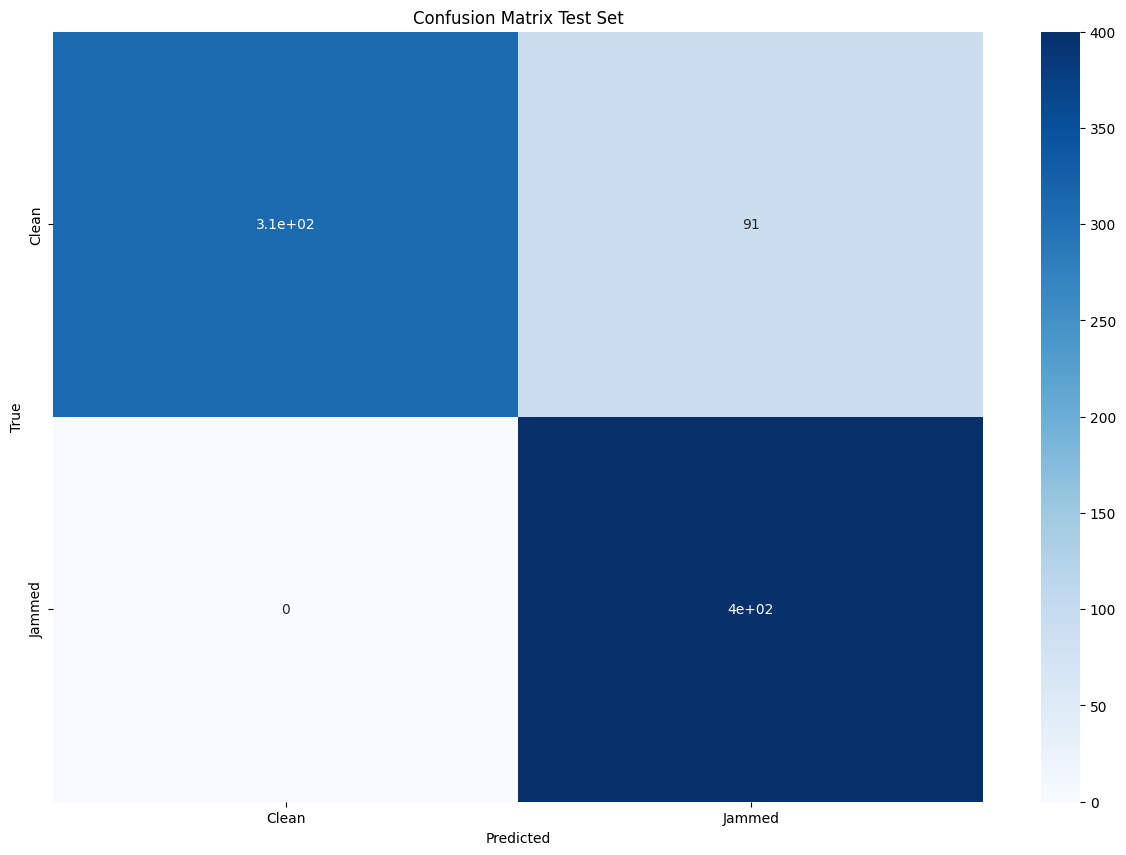

In [59]:
def print_confusion_matrix(gt, pred):
    class_names= {0: "Clean", 1:"Jammed"}
    num_classes = 2
    cm = confusion_matrix(y_true=gt, y_pred=pred)
    df_cm = pd.DataFrame(cm, index = class_names.values(), columns = class_names.values())
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.title('Confusion Matrix Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print_confusion_matrix(labels_test,pred) ## print the confusion matrix of our predictor for a given threshold